In [1]:
import pandas as pd
import numpy as np
from collections import Counter


In [2]:
from google.colab import drive
!cd ~
drive.mount('/content/drive')
%cd "/content/drive/My Drive/Colab Notebooks/unsupervised_project/MSA"
!ls

Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks/unsupervised_project/MSA
'family msa_gen_vector_iadf+.ipynb'
 msa_gen_vector_iadf+.ipynb
 msa_gen_vector_iadf.ipynb
 msa.ipynb
 RE_df.gsheet
 RE_df.tsv
 res_of_iadf_pca.csv
 res_of_iadf_plus_pca
 res_of_iadf_plus_pca.csv
 res_of_pca_tfidf.csv
'results summerizetion.ipynb'
'submission of PCA msa_gen_vector_iadf+.ipynb'
'submission of PCA msa_gen_vector_iadf.ipynb'
'submission of PCA msa_gen_vector_tf_idf.ipynb'
'submission of TSNE msa_gen_vector_iadf+.ipynb'


# data

In [3]:
df_data = pd.read_csv('RE_df.tsv', sep='\t')
df_data['family_lable'] =  df_data['msa'].str.split('_').str[0]
familys_with_re = list(df_data.query('is_RE==1').family_lable.unique())
familys_with_out_re = list(df_data.query('is_RE==0').family_lable.unique())

df_data = df_data.query('family_lable in @familys_with_re and family_lable in @familys_with_out_re')
family_lables = df_data['family_lable'].to_list()
dataset = df_data['seq'].tolist()
all_true_lables = df_data['is_RE'].tolist()

In [4]:
len(df_data.family_lable.unique())

48

In [5]:
def kmers_extraction(msa, kmer_size=3):
  kmers=[]
  for i,_ in enumerate(msa):
    if i < len(msa)-kmer_size+1:
      kmers.append(msa[i:i+kmer_size])
  return kmers


In [6]:
def preprocess(dataset):
 return [kmers_extraction(i) for i in dataset ]
processed_text = preprocess(dataset)

In [7]:

DF = {}
for i in range(len(processed_text)):
    tokens = processed_text[i]
    for w in tokens:
        try:
            DF[w].add(i)
        except:
            DF[w] = {i}

In [8]:
total_vocab = [x for x in DF]
# total_vocab

In [9]:
def doc_freq(word):
    c = 0
    try:
        c = DF[word]
    except:
        pass
    return len(c)

# tf idf

In [10]:
import math 

 # mean df for ne algo

tf_idf = {}

N = len(dataset)


def gen_vector_tf_idf(tokens):

    Q = np.zeros((len(total_vocab)))
    
    counter = Counter(tokens)
    words_count = len(tokens)

    query_weights = {}
    
    for token in np.unique(tokens):
        
        tf = counter[token]/words_count
        df = doc_freq(token)
        idf = math.log((N+1)/(df+1))

        try:
            ind = total_vocab.index(token)
            Q[ind] = tf*idf
        except:
            pass
    return Q

# the run

# PCA

In [11]:
vecs = [ gen_vector_tf_idf(i)  for i in preprocess(dataset)]
# vecs

In [12]:
from sklearn.decomposition import PCA
import seaborn as sns
from numpy import reshape

def pca(vecs):
  x = np.array(vecs)
  # x = reshape(x, [x.shape[0], x.shape[1]*x.shape[2]])
  pca = PCA(n_components=2)
  z = pca.fit_transform(x)
  df = pd.DataFrame()

  df["y"] = family_lables
  df["comp-1"] = z[:,0]
  df["comp-2"] = z[:,1]
  df['color'] = all_true_lables
  # df = df.query('y=="Salmonella"')
  return df, z
  

In [13]:
df , z = pca(vecs)


In [14]:
len(df.query('color==1').y.unique())

48

# families clusters


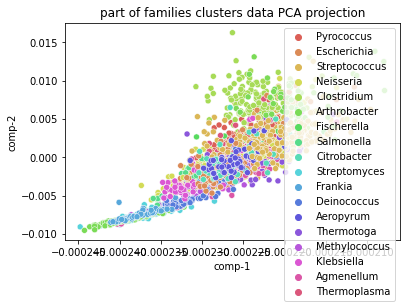

In [15]:
## families clusters
part_of_families = list(set(family_lables))[30:50]
df2= df.query('y in @part_of_families')

sns.scatterplot(x="comp-1", y="comp-2", hue=df2.y.tolist(),
                  palette=sns.color_palette("hls", len(df2.y.unique())),sizes=[600,800],
                  data=df2).set(title=f"part of families clusters data PCA projection")
  
sns.set(rc={'figure.figsize':(11.7,8.27)})

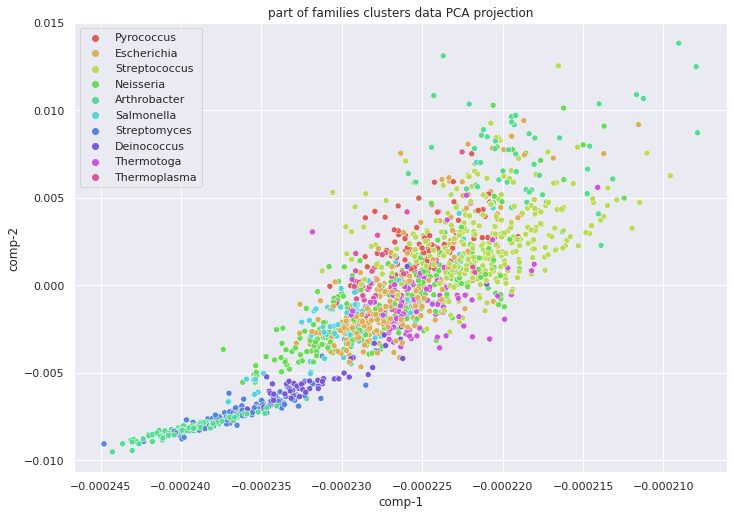

In [16]:
## families clusters
part_of_families = list(set(family_lables))[30:40]
df2= df.query('y in @part_of_families')

sns.scatterplot(x="comp-1", y="comp-2", hue=df2.y.tolist(),
                  palette=sns.color_palette("hls", len(df2.y.unique())),sizes=[600,800],
                  data=df2).set(title=f"part of families clusters data PCA projection")
  
sns.set(rc={'figure.figsize':(11.7,8.27)})

In [17]:
# tsne visualizetion by family

In [ ]:
import matplotlib.pyplot as plt

for i in set(family_lables):
  df1= df.query('y==@i') ### very bad example: Thermococcus - maybe good
  if len(df1.color.unique())>1:
    plt.figure()
    sns.scatterplot(x="comp-1", y="comp-2", hue=df1.color.tolist(),
                      palette=sns.color_palette("hls", 2),sizes=[600,800],
                      data=df1).set(title=f"{i} data PCA projection")
      
    sns.set(rc={'figure.figsize':(11.7,8.27)})


<ipython-input-18-93fa05f27660>:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


# general function

In [ ]:
def confusion_matrix_re(true_lables, pred_lables):
  tp = 0
  fp = 0
  fn = 0
  tn = 0
  sum = 0
  for true, pred in zip(true_lables, pred_lables):
    if true == 1 and  pred == -1:
      tp +=1
    if true == 1 and  pred != -1:
      fp += 1
    if true == 0 and  pred == -1:
      fn +=1
    if true == 0 and  pred != -1:
      tn +=1
  return tp/len(true_lables) , fp/len(true_lables), fn/len(true_lables),  tn/len(true_lables)



In [ ]:
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.cluster import fowlkes_mallows_score
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics.cluster import normalized_mutual_info_score 
from sklearn.metrics import homogeneity_completeness_v_measure


all_res_table= []


def clustering_function(familyes,df_data, df, algorithem, params):
  familyes =  sorted(familyes)
  num_of_family = 0
  for  i  in familyes:
    d = {}
    d['algo'] = algorithem
    df1= df.query('y==@i')
    df_data1 = df_data.query('family_lable==@i')
   
    true_labels = df_data1.is_RE.tolist()

    if len(df1.color.unique())> 1 and  len(set(true_labels))> 1:
      print('-------------------')
      print(i)
      d['family_lable'] = i 
      print (num_of_family ,i)
      if params:
        algo = algorithem(**params[num_of_family])
      else:
        algo = algorithem()
      pred_labels = algo.fit_predict(df1[['comp-1','comp-2']].values)
      if len(set(pred_labels))>1:
        ari = adjusted_rand_score(true_labels, pred_labels)
        print(f"Adjusted Rand Index: {ari}")

        d['ari'] = ari 

        fmi = fowlkes_mallows_score(true_labels, pred_labels)
        print(f"fowlkes_mallows_score: {fmi}")

        d['fmi'] = fmi 

        homogeneity, completeness, v_measure = homogeneity_completeness_v_measure(true_labels, pred_labels)
        print(f"homogeneity_completeness_v_measure: {homogeneity} {completeness} {v_measure}")


        d['homogeneity'] = homogeneity 
        d['completeness'] = completeness 
        d['v_measure'] = v_measure 

        tp, fp, fn, tn = confusion_matrix_re(true_labels, pred_labels)
        d['tp'] = tp
        d['fp'] = fp
        d['fn'] = fn
        d['tn'] = tn

        d['family_size'] = len(true_labels)
        d['re_size'] = np.sum(true_labels)


        all_res_table.append(d)
      else:
        print('caoudnot seperate to clusters')

      num_of_family +=1

      markers = ["." if label == 0 else "d" for label in true_labels]
      if -1 in pred_labels:
        colors = ["red" if label == -1 else "black" for label in pred_labels]
      else:
        colors = ["blue" if label == 1 else  "orange" for label in pred_labels]

    

      for i in range(len(markers)):
        plt.scatter(df1['comp-1'].values[i], df1['comp-2'].values[i], c=colors[i] ,marker=markers[i])
      plt.show()





# dbscan

In [ ]:
from sklearn.cluster import DBSCAN

from sklearn.cluster import KMeans

# params for dbscan
values = []
familyes = sorted(set(family_lables))
print(familyes)
for i in familyes:    
  df1= df.query('y==@i')
  df_data1 = df_data.query('family_lable==@i')
  true_labels = df_data1.is_RE.tolist()
  if len(set(true_labels))> 1:
    neigh = NearestNeighbors(n_neighbors=2)
    nbrs = neigh.fit(df1[['comp-1','comp-2']])
    distances, indices = nbrs.kneighbors(df1[['comp-1','comp-2']])
    distances = np.sort(distances[:,1], axis=0)
    values.append({'eps':np.round(np.quantile(distances,0.95),5)})
print(len(values))
# clustering_function(familyes,df_data, df, DBSCAN, params = values)

In [ ]:

# from sklearn.cluster import KMeans

# # params for dbscan
# values = []
# familyes = sorted(set(family_lables))
# print(familyes)
# for i in familyes:    
#   df1= df.query('y==@i')
#   df_data1 = df_data.query('family_lable==@i')
#   true_labels = df_data1.is_RE.tolist()
# # print(len(familyes))
#   values.append({'n_clusters':2})
# clustering_function(familyes,df_data, df, KMeans, params=values)

# IsolationForest

['Aeropyrum', 'Agmenellum', 'Agrobacterium', 'Anabaena', 'Arthrobacter', 'Arthrospira', 'Bacillus', 'Bacteroides', 'Bifidobacterium', 'Brevibacterium', 'Chlorella', 'Chlorobium', 'Citrobacter', 'Clostridium', 'Corynebacterium', 'Deinococcus', 'Desulfovibrio', 'Diplococcus', 'Enterobacter', 'Escherichia', 'Eubacterium', 'Fischerella', 'Flavobacterium', 'Frankia', 'Haemophilus', 'Helicobacter', 'Klebsiella', 'Lactococcus', 'Methanocaldococcus', 'Methylococcus', 'Moraxella', 'Mycoplasma', 'Neisseria', 'Nocardia', 'Pseudomonas', 'Pyrococcus', 'Rhodobacter', 'Salmonella', 'Shewanella', 'Sphaerotilus', 'Streptococcus', 'Streptomyces', 'Sulfolobus', 'Thermococcus', 'Thermoplasma', 'Thermotoga', 'Thermus', 'Xanthomonas']
-------------------
Aeropyrum
0 Aeropyrum
Adjusted Rand Index: -0.02746448557899268
fowlkes_mallows_score: 0.7870490257199462
homogeneity_completeness_v_measure: 0.04991572095310864 0.009239302120694964 0.015592468821546548


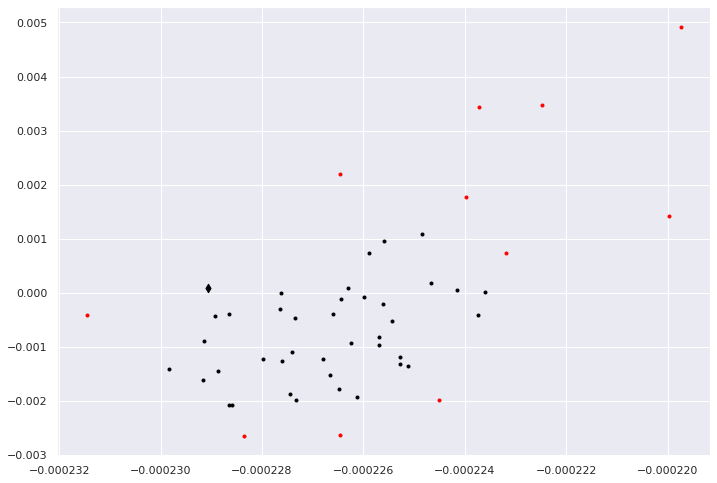

-------------------
Agmenellum
1 Agmenellum
Adjusted Rand Index: 0.06328078524687686
fowlkes_mallows_score: 0.7726039985050023
homogeneity_completeness_v_measure: 0.2680836160455999 0.04402378816165864 0.07562817263101922


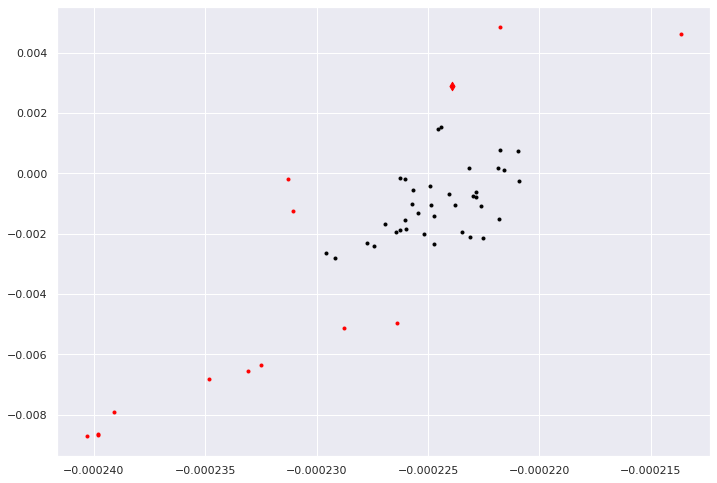

-------------------
Agrobacterium
2 Agrobacterium
Adjusted Rand Index: -0.026399413346370082
fowlkes_mallows_score: 0.7734309162699123
homogeneity_completeness_v_measure: 0.05512581036683671 0.009751076938919133 0.0165709558682727


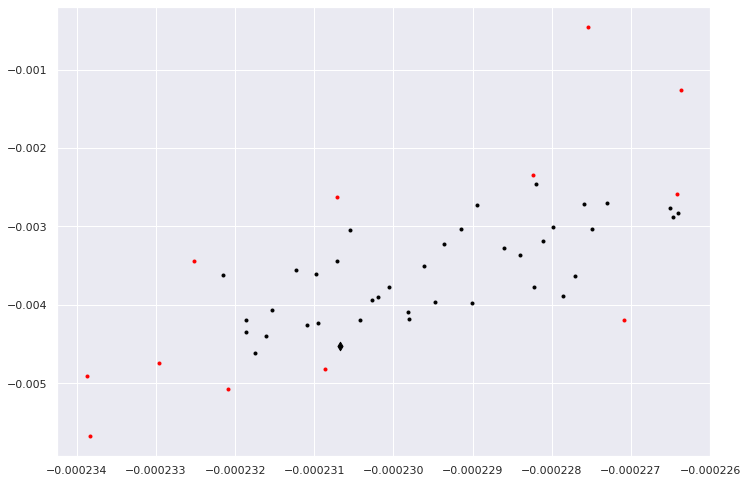

-------------------
Anabaena
3 Anabaena
Adjusted Rand Index: 0.028293345405160705
fowlkes_mallows_score: 0.6956820473701277
homogeneity_completeness_v_measure: 0.017933016341319927 0.007439346987410409 0.010516161176275891


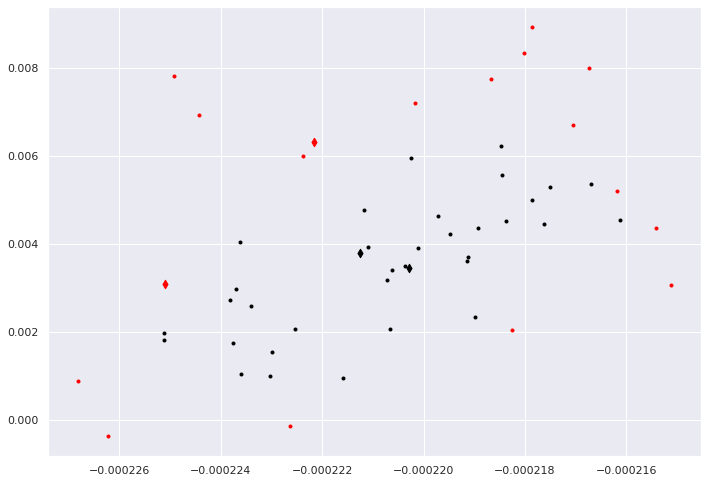

-------------------
Arthrobacter
4 Arthrobacter
Adjusted Rand Index: 0.06821791124008111
fowlkes_mallows_score: 0.7878177914705412
homogeneity_completeness_v_measure: 0.1242953242410055 0.026796221847719612 0.04408777551379848


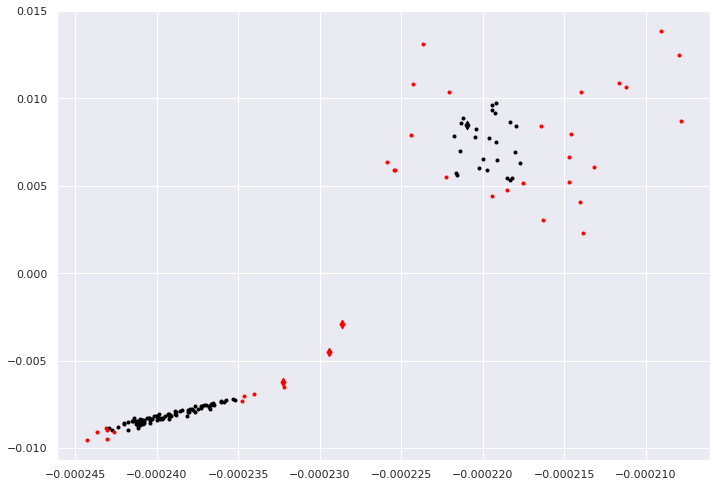

-------------------
Arthrospira
5 Arthrospira
Adjusted Rand Index: 0.021520984537709058
fowlkes_mallows_score: 0.7100164672066606
homogeneity_completeness_v_measure: 0.19334832285060077 0.02786286266603044 0.0487067392520129


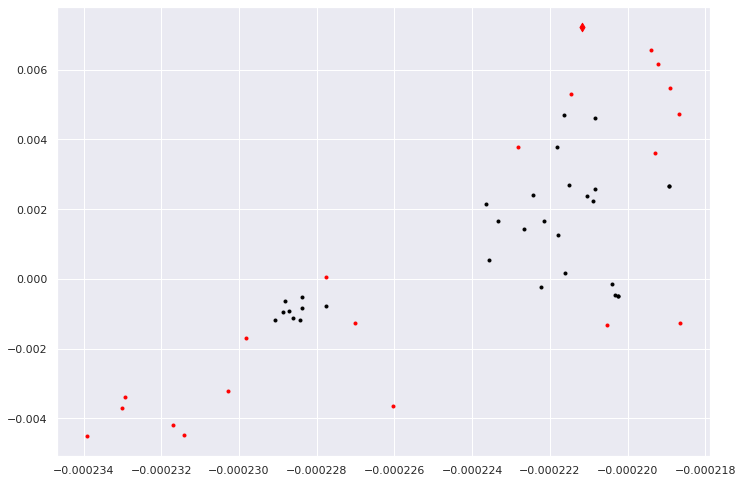

-------------------
Bacillus
6 Bacillus
Adjusted Rand Index: 0.04932259850338742
fowlkes_mallows_score: 0.7957192536119817
homogeneity_completeness_v_measure: 0.006165235968962687 0.005145575716591079 0.0056094450815525375


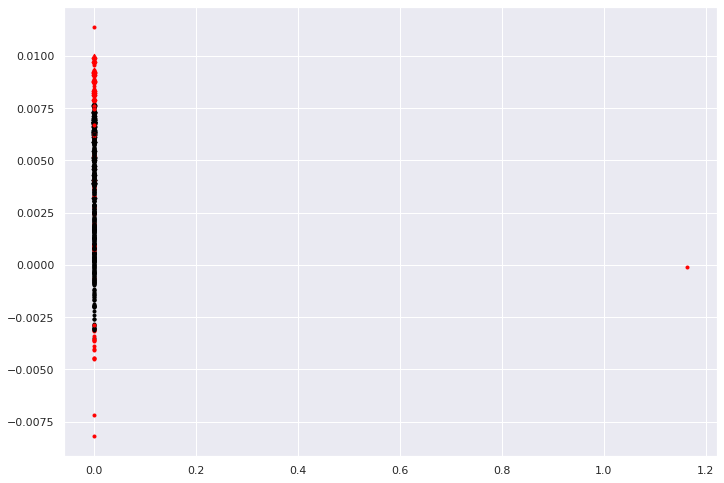

-------------------
Bacteroides
7 Bacteroides
Adjusted Rand Index: 0.022274109803680605
fowlkes_mallows_score: 0.7299988454109025
homogeneity_completeness_v_measure: 0.019707214157018583 0.005204997031395811 0.008234996918464384


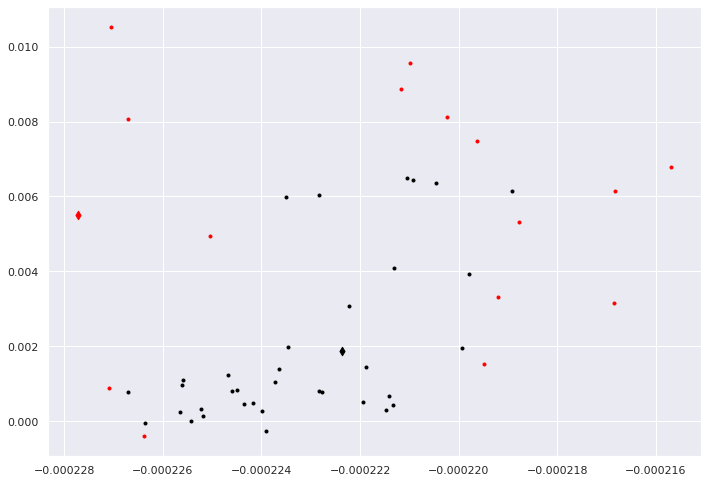

-------------------
Bifidobacterium
8 Bifidobacterium
Adjusted Rand Index: -0.038084849059735824
fowlkes_mallows_score: 0.7806946955964671
homogeneity_completeness_v_measure: 0.05403728222823186 0.013720000259241303 0.02188374441720279


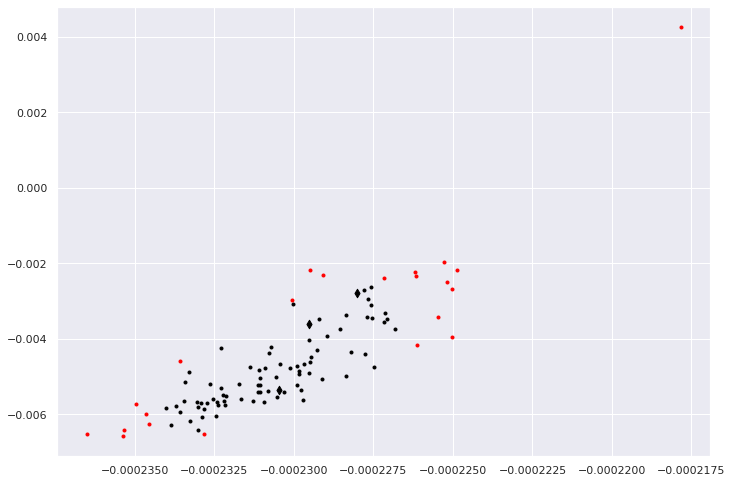

-------------------
Brevibacterium
9 Brevibacterium
Adjusted Rand Index: 0.09987085665088248
fowlkes_mallows_score: 0.8157229223856225
homogeneity_completeness_v_measure: 0.3191738423312118 0.05907845268009641 0.09970221986531673


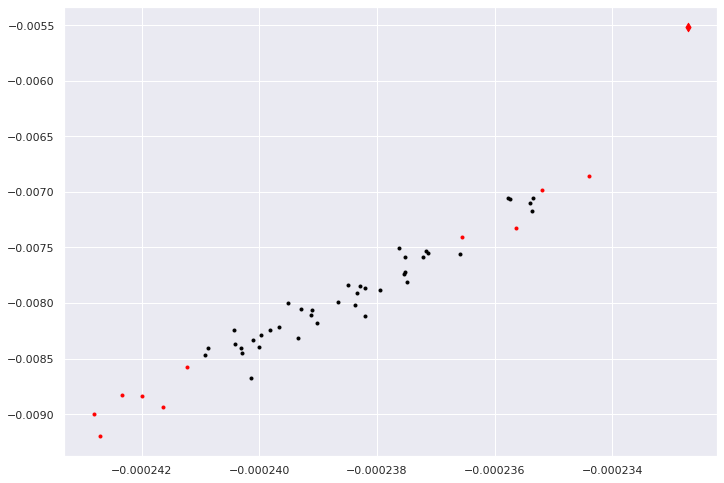

-------------------
Chlorella
10 Chlorella
Adjusted Rand Index: 0.10498570407433881
fowlkes_mallows_score: 0.7741704957902397
homogeneity_completeness_v_measure: 0.05690690909825109 0.028367397129162614 0.03786136671644444


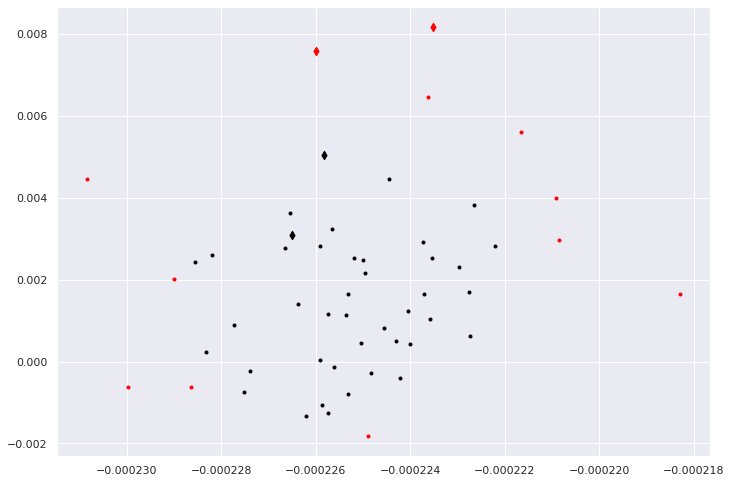

-------------------
Chlorobium
11 Chlorobium
Adjusted Rand Index: 0.04241745486202425
fowlkes_mallows_score: 0.8181253345900329
homogeneity_completeness_v_measure: 0.048051250872876185 0.009369995223738945 0.015682000018459107


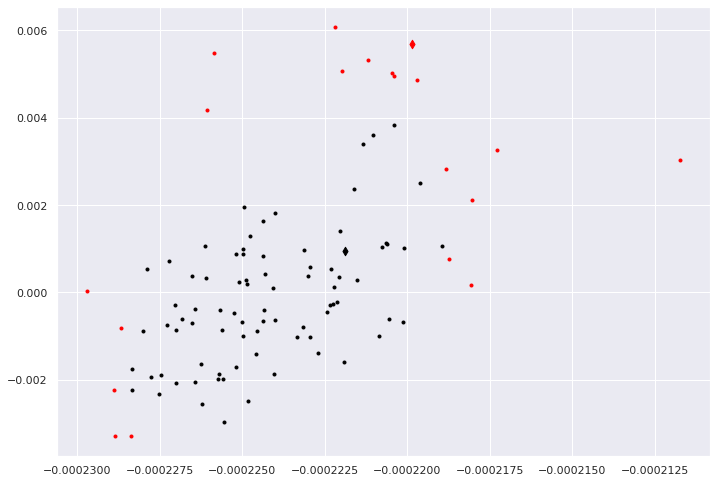

-------------------
Citrobacter
12 Citrobacter
Adjusted Rand Index: 0.21070615034168566
fowlkes_mallows_score: 0.749714509851832
homogeneity_completeness_v_measure: 0.3652539701988219 0.1759952509932438 0.23753554423539483


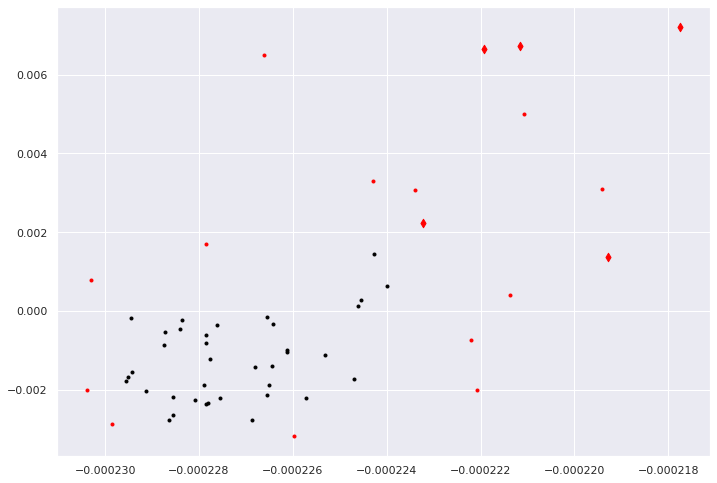

-------------------
Clostridium
13 Clostridium
Adjusted Rand Index: 0.06385369840621169
fowlkes_mallows_score: 0.8279130651304717
homogeneity_completeness_v_measure: 0.05795052370949922 0.01472244560467483 0.023479801117996135


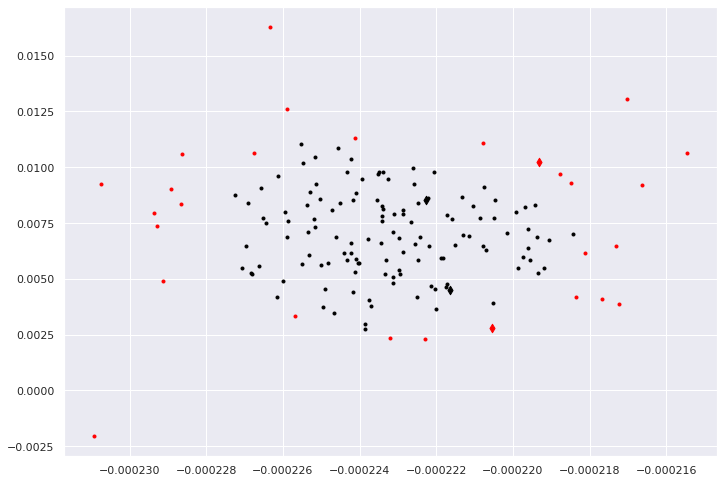

-------------------
Corynebacterium
14 Corynebacterium
Adjusted Rand Index: 0.09987085665088248
fowlkes_mallows_score: 0.8157229223856225
homogeneity_completeness_v_measure: 0.3191738423312118 0.05907845268009641 0.09970221986531673


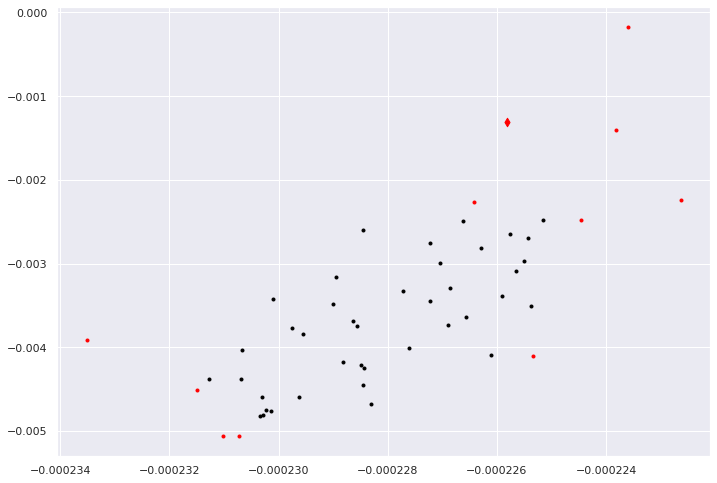

-------------------
Deinococcus
15 Deinococcus
Adjusted Rand Index: 0.07373486494877367
fowlkes_mallows_score: 0.7861995275653009
homogeneity_completeness_v_measure: 0.28372762067795226 0.04823735533003574 0.08245610859417078


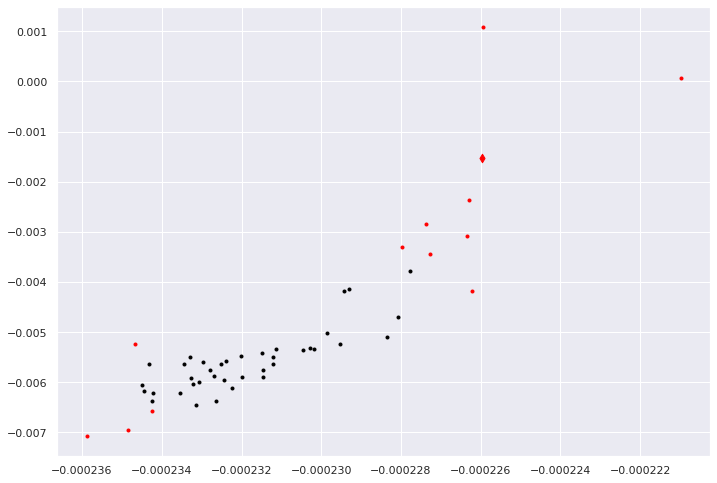

-------------------
Desulfovibrio
16 Desulfovibrio
Adjusted Rand Index: 0.19181594297728227
fowlkes_mallows_score: 0.8842465358874383
homogeneity_completeness_v_measure: 0.4167331755524028 0.10055906833644059 0.1620217599374672


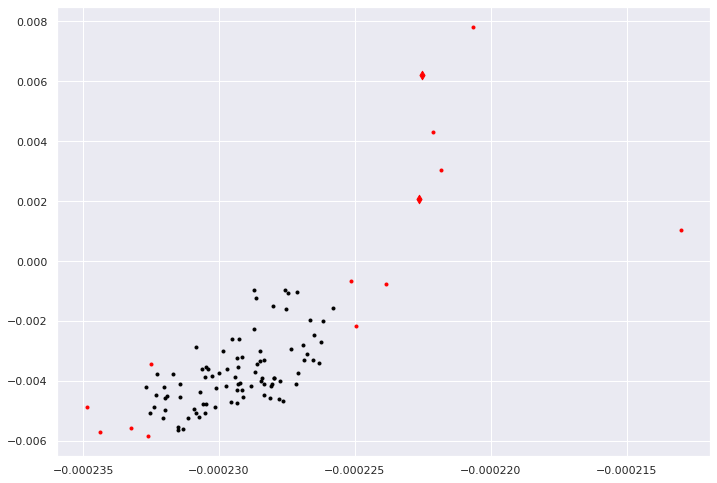

-------------------
Diplococcus
17 Diplococcus
Adjusted Rand Index: 0.09987085665088248
fowlkes_mallows_score: 0.8157229223856225
homogeneity_completeness_v_measure: 0.3191738423312118 0.05907845268009641 0.09970221986531673


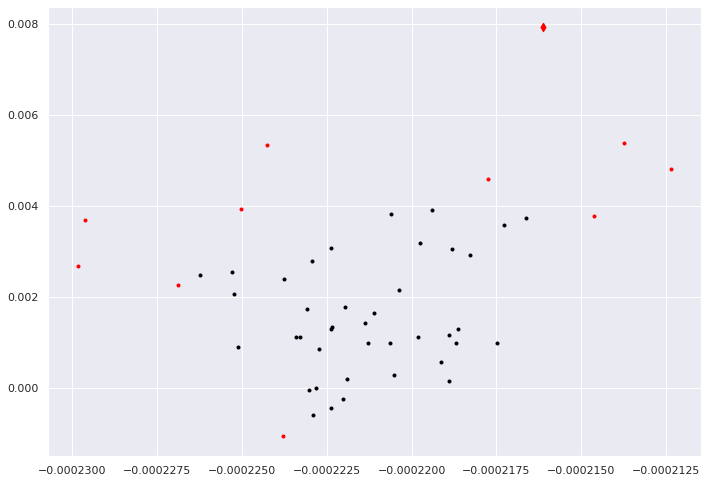

-------------------
Enterobacter
18 Enterobacter
Adjusted Rand Index: 0.3436218824735224
fowlkes_mallows_score: 0.816441787236235
homogeneity_completeness_v_measure: 0.45541033528116887 0.24456336240478538 0.3182310513622267


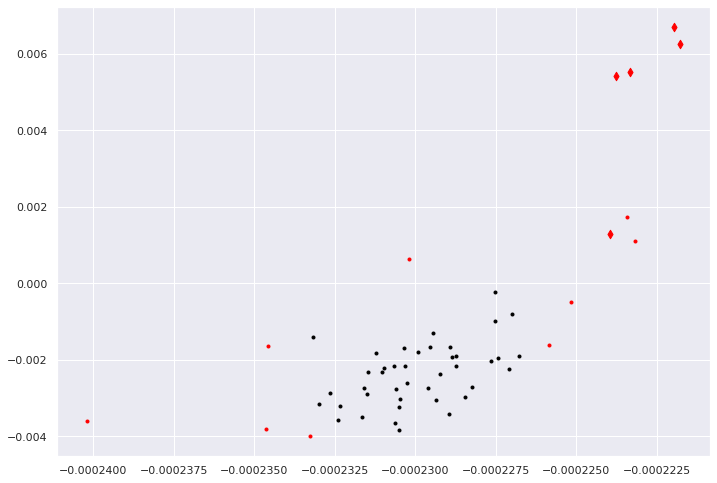

-------------------
Escherichia
19 Escherichia
Adjusted Rand Index: 0.16447323260601138
fowlkes_mallows_score: 0.8119923894694149
homogeneity_completeness_v_measure: 0.16500663732999069 0.06518908031067318 0.09345639478393784


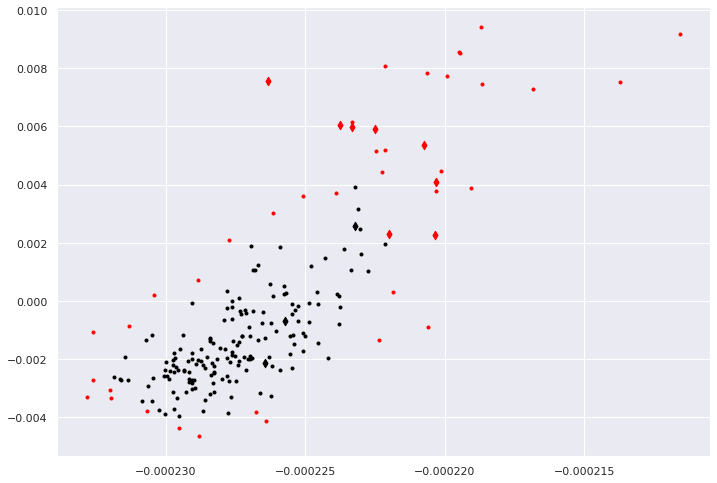

-------------------
Eubacterium
20 Eubacterium
Adjusted Rand Index: 0.038901601830663615
fowlkes_mallows_score: 0.7369918385607233
homogeneity_completeness_v_measure: 0.22729774050744764 0.03446312714887227 0.05985150493957278


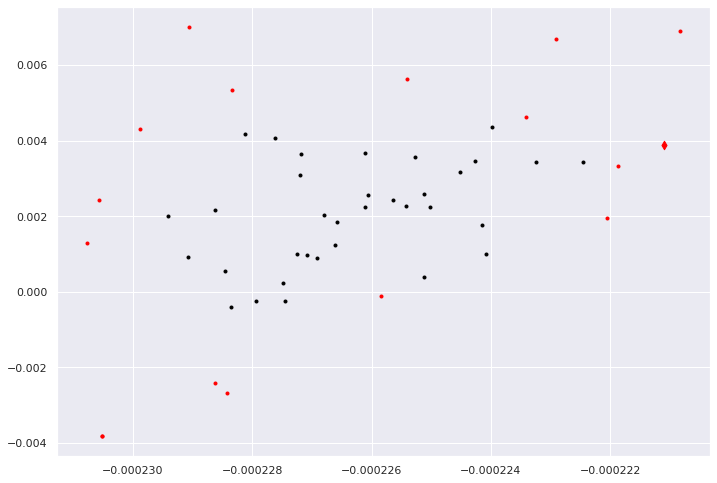

-------------------
Fischerella
21 Fischerella
Adjusted Rand Index: -0.026399413346370082
fowlkes_mallows_score: 0.7734309162699123
homogeneity_completeness_v_measure: 0.05512581036683671 0.009751076938919133 0.0165709558682727


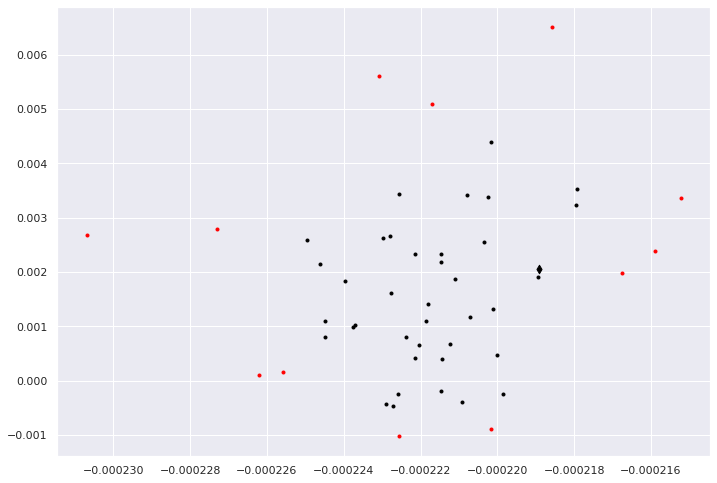

-------------------
Flavobacterium
22 Flavobacterium
Adjusted Rand Index: 0.13005445360509107
fowlkes_mallows_score: 0.7804323062703838
homogeneity_completeness_v_measure: 0.3226998307586119 0.09031484659197692 0.14113099271521276


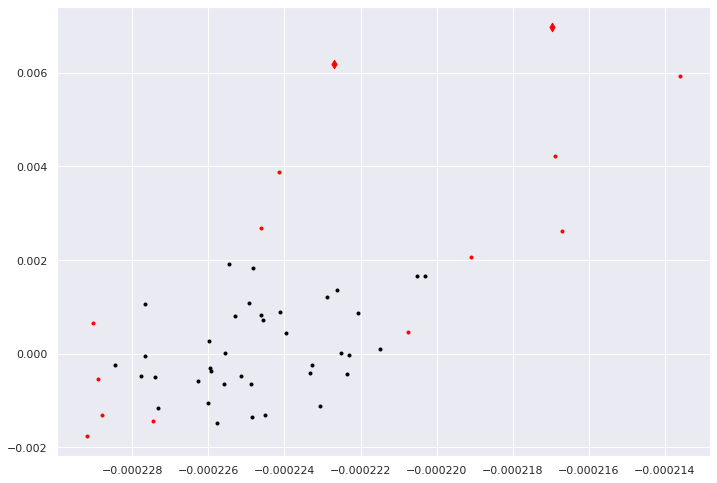

-------------------
Frankia
23 Frankia
Adjusted Rand Index: 0.09987085665088248
fowlkes_mallows_score: 0.8157229223856225
homogeneity_completeness_v_measure: 0.3191738423312118 0.05907845268009641 0.09970221986531673


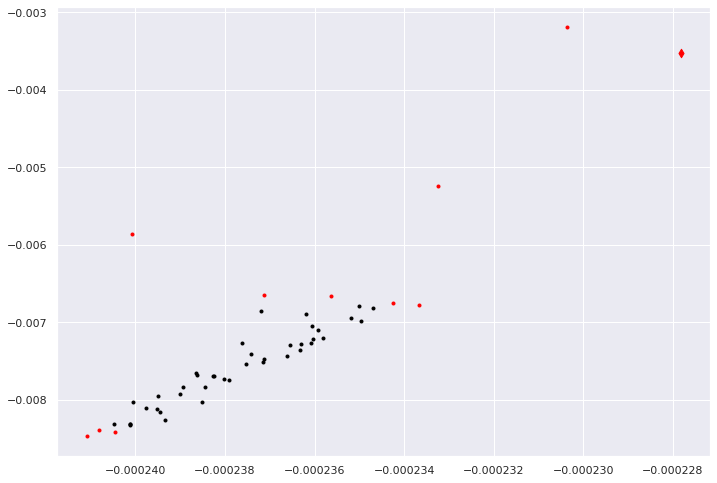

-------------------
Haemophilus
24 Haemophilus
Adjusted Rand Index: 0.15699061274541562
fowlkes_mallows_score: 0.7811714728056952
homogeneity_completeness_v_measure: 0.12504224834909752 0.059821946517298816 0.08092719846099558


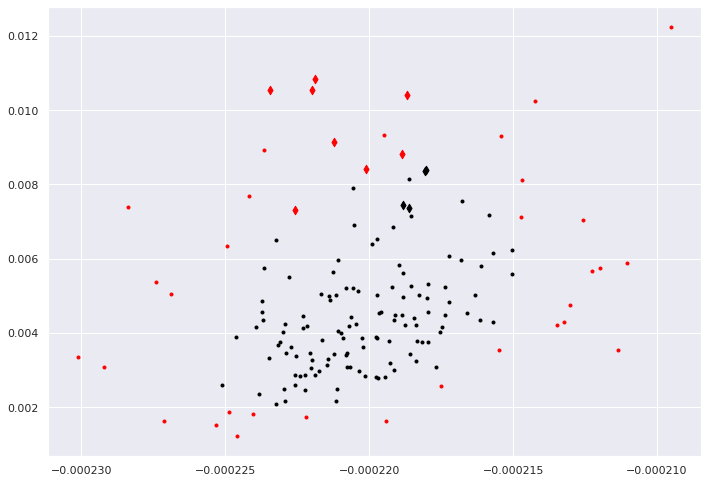

-------------------
Helicobacter
25 Helicobacter
Adjusted Rand Index: 0.07797210834693355
fowlkes_mallows_score: 0.8523791707010954
homogeneity_completeness_v_measure: 0.0586024814499644 0.01703530000619747 0.02639714791704636


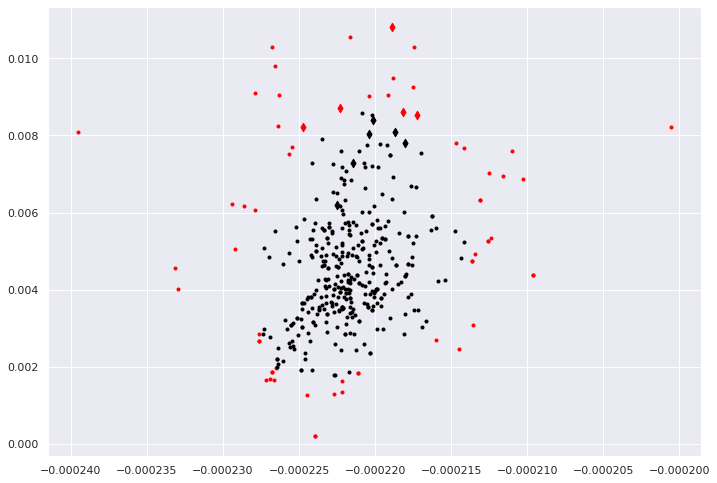

-------------------
Klebsiella
26 Klebsiella
Adjusted Rand Index: 0.10054557302203161
fowlkes_mallows_score: 0.817831943928969
homogeneity_completeness_v_measure: 0.3191738423312055 0.05907845268009472 0.09970221986531402


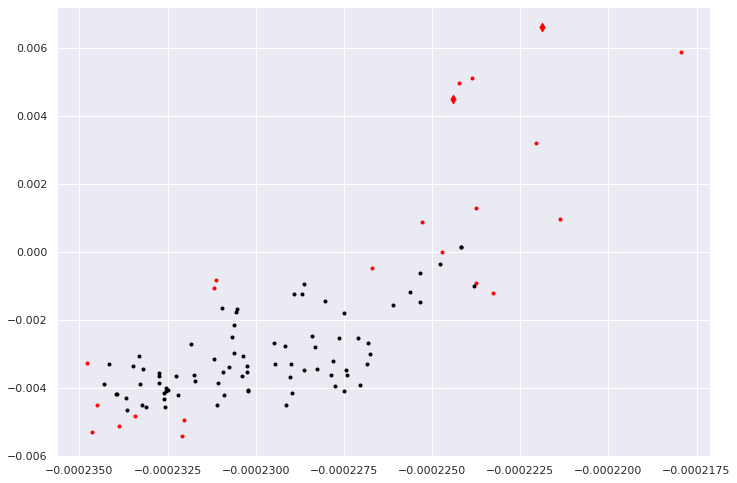

-------------------
Lactococcus
27 Lactococcus
Adjusted Rand Index: -0.09077367563406612
fowlkes_mallows_score: 0.7708547611282796
homogeneity_completeness_v_measure: 0.049380025491908175 0.03627052046444513 0.041822015379838304


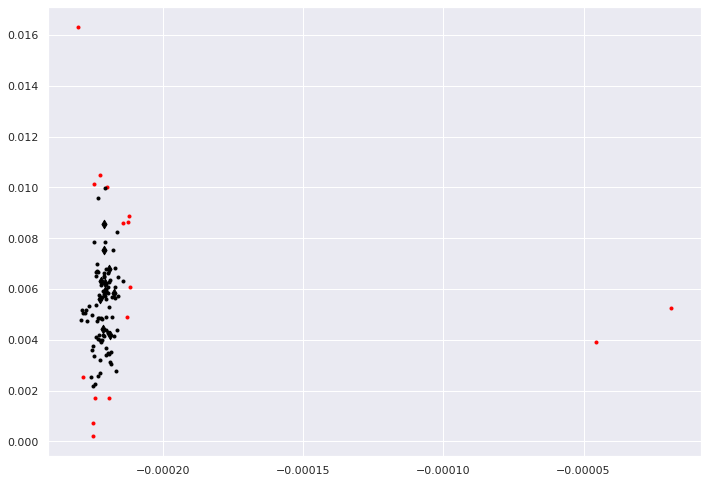

-------------------
Methanocaldococcus
28 Methanocaldococcus
Adjusted Rand Index: -0.019338657514355487
fowlkes_mallows_score: 0.7196733612916236
homogeneity_completeness_v_measure: 0.0012444684614212307 0.0006932589087088306 0.0008904646347948652


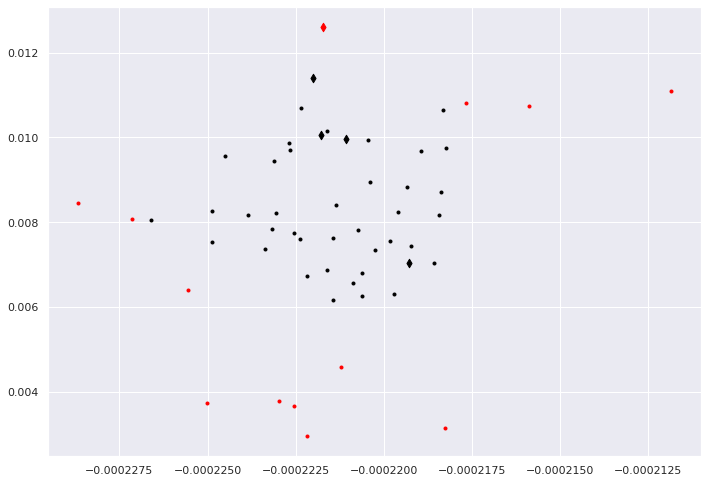

-------------------
Methylococcus
29 Methylococcus
Adjusted Rand Index: 0.07373486494877367
fowlkes_mallows_score: 0.7861995275653009
homogeneity_completeness_v_measure: 0.28372762067795226 0.04823735533003574 0.08245610859417078


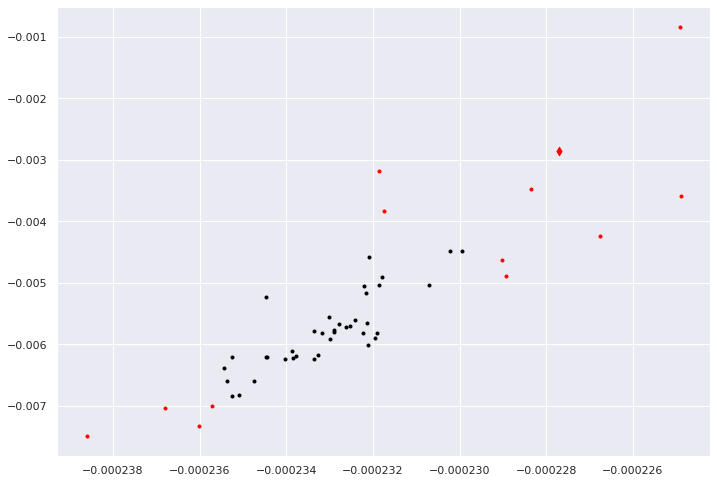

-------------------
Moraxella
30 Moraxella
Adjusted Rand Index: 0.23891109649344736
fowlkes_mallows_score: 0.7858871004070691
homogeneity_completeness_v_measure: 0.38994017845195134 0.1742673359234786 0.24088242122606737


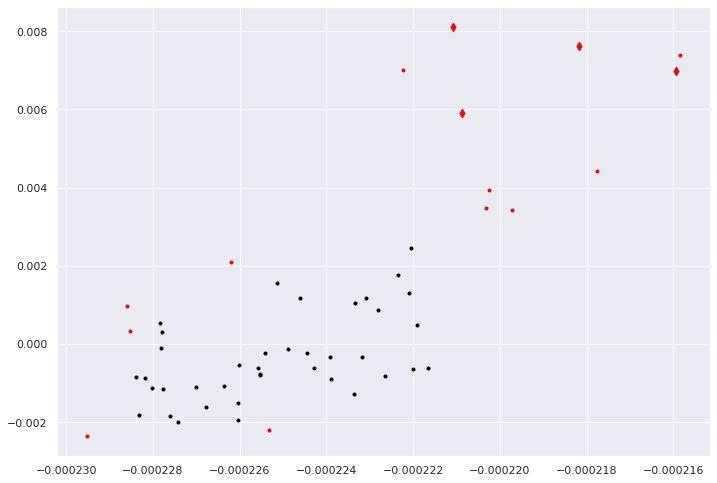

-------------------
Mycoplasma
31 Mycoplasma
Adjusted Rand Index: 0.012413108242303872
fowlkes_mallows_score: 0.7096982566310202
homogeneity_completeness_v_measure: 0.012227537469169077 0.00309034897326249 0.004933756103414082


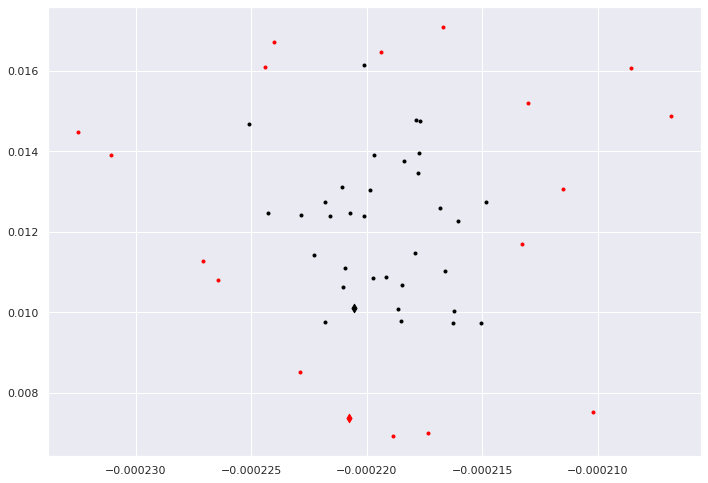

-------------------
Neisseria
32 Neisseria
Adjusted Rand Index: 0.1820256390602179
fowlkes_mallows_score: 0.8382633061261299
homogeneity_completeness_v_measure: 0.09610281300209132 0.05450320560945103 0.06955779622871162


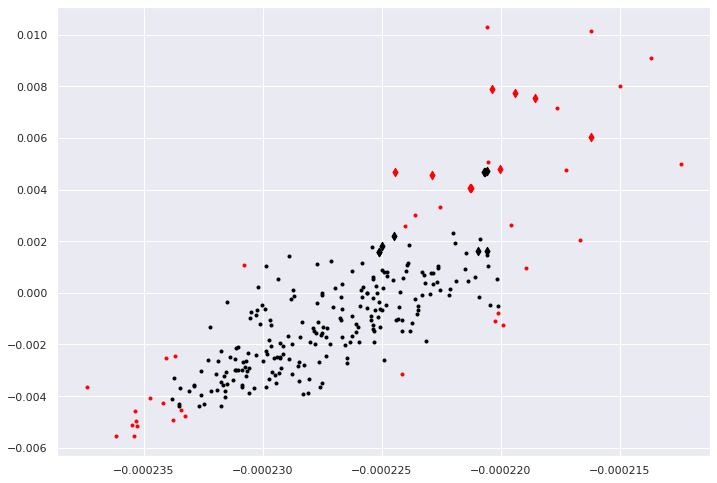

-------------------
Nocardia
33 Nocardia
Adjusted Rand Index: 0.17419515090517296
fowlkes_mallows_score: 0.8396258177002781
homogeneity_completeness_v_measure: 0.376729710797896 0.10079255688319132 0.15903572827956328


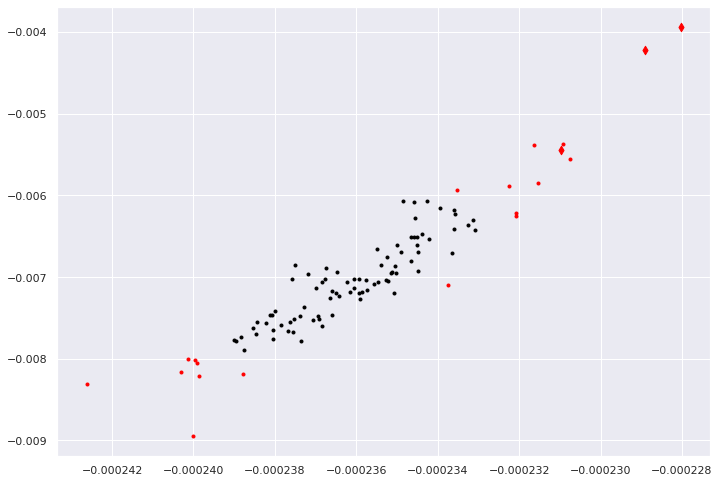

-------------------
Pseudomonas
34 Pseudomonas
Adjusted Rand Index: 0.10498570407433881
fowlkes_mallows_score: 0.7741704957902397
homogeneity_completeness_v_measure: 0.05690690909825109 0.028367397129162614 0.03786136671644444


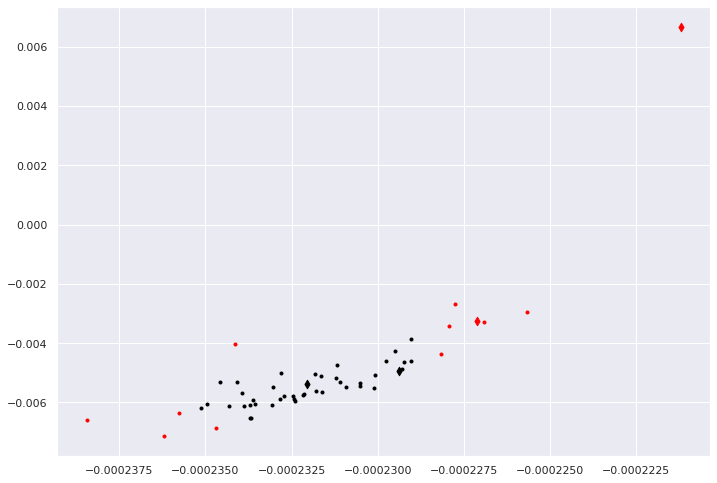

-------------------
Pyrococcus
35 Pyrococcus
Adjusted Rand Index: 0.07044324344286607
fowlkes_mallows_score: 0.7933493137151824
homogeneity_completeness_v_measure: 0.0970991228427477 0.023553930405692355 0.03791144807885617


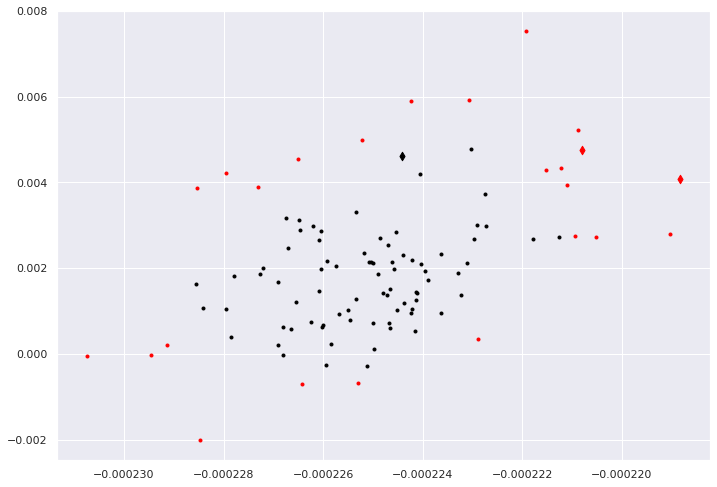

-------------------
Rhodobacter
36 Rhodobacter
Adjusted Rand Index: 0.1364441819255759
fowlkes_mallows_score: 0.8480813153836058
homogeneity_completeness_v_measure: 0.3621462226994919 0.07500088265183384 0.12426611554323588


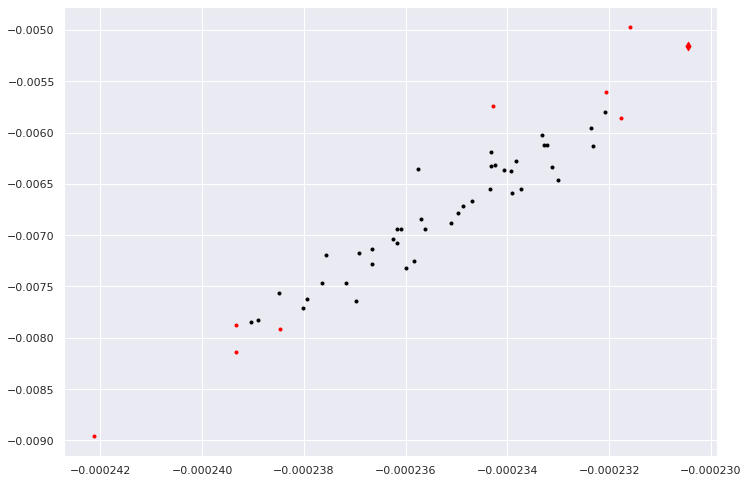

-------------------
Salmonella
37 Salmonella
Adjusted Rand Index: 0.07793846242793914
fowlkes_mallows_score: 0.7378595214973718
homogeneity_completeness_v_measure: 0.2663639404258989 0.06798614650421048 0.10832393102394716


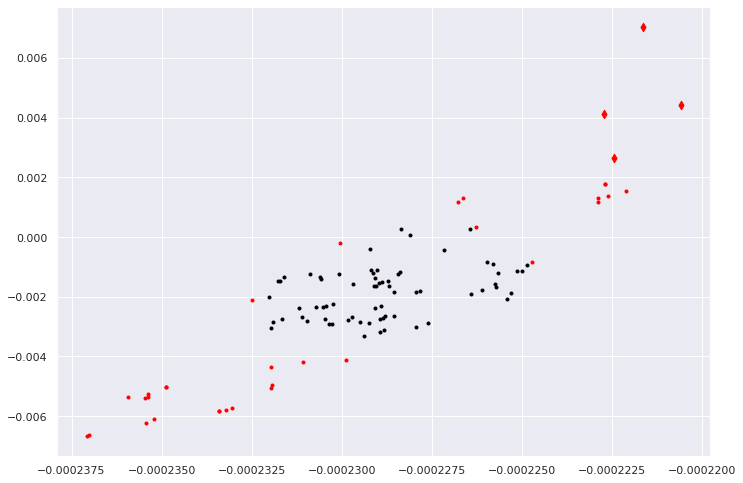

-------------------
Shewanella
38 Shewanella
Adjusted Rand Index: 0.08579809337570277
fowlkes_mallows_score: 0.8005864881025361
homogeneity_completeness_v_measure: 0.3006782061690191 0.0531862715976349 0.09038461751077799


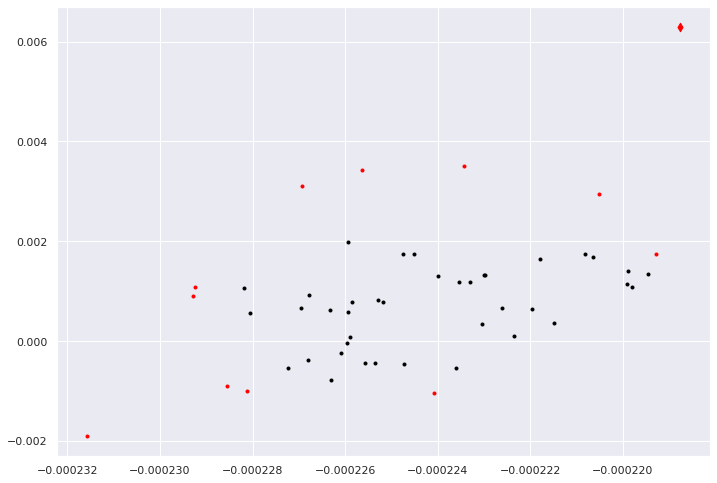

-------------------
Sphaerotilus
39 Sphaerotilus
Adjusted Rand Index: 0.3866739900376901
fowlkes_mallows_score: 0.8778536245155478
homogeneity_completeness_v_measure: 0.5030892721804947 0.2401984273146218 0.3251533748202609


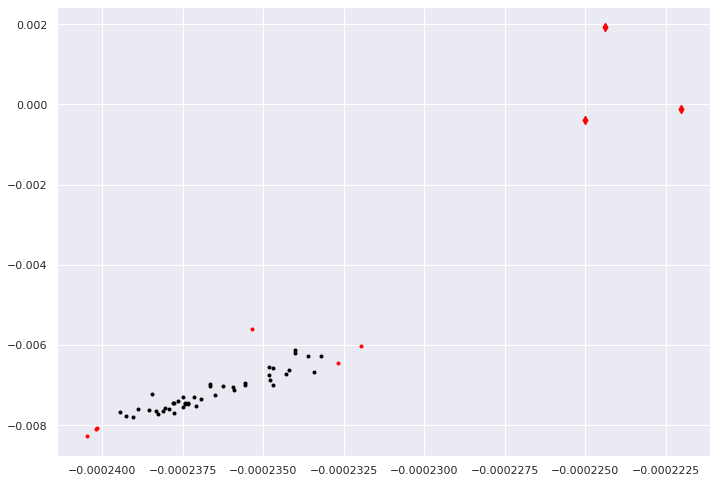

-------------------
Streptococcus
40 Streptococcus
Adjusted Rand Index: -0.035141680694458194
fowlkes_mallows_score: 0.7703217610320576
homogeneity_completeness_v_measure: 0.009282133743439804 0.004414196582419926 0.005983086282680575


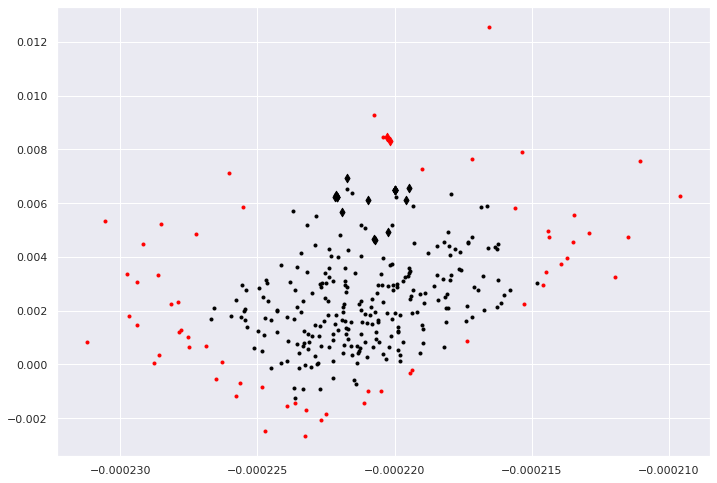

-------------------
Streptomyces
41 Streptomyces
Adjusted Rand Index: 0.393281807372176
fowlkes_mallows_score: 0.8999220199187176
homogeneity_completeness_v_measure: 0.5190869726016221 0.23348243437609592 0.3220903982867667


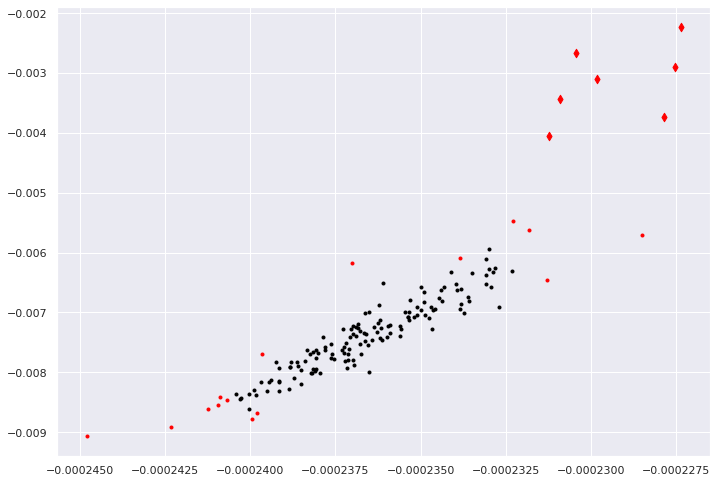

-------------------
Sulfolobus
42 Sulfolobus
Adjusted Rand Index: -0.02746448557899268
fowlkes_mallows_score: 0.7870490257199462
homogeneity_completeness_v_measure: 0.04991572095310864 0.009239302120694964 0.015592468821546548


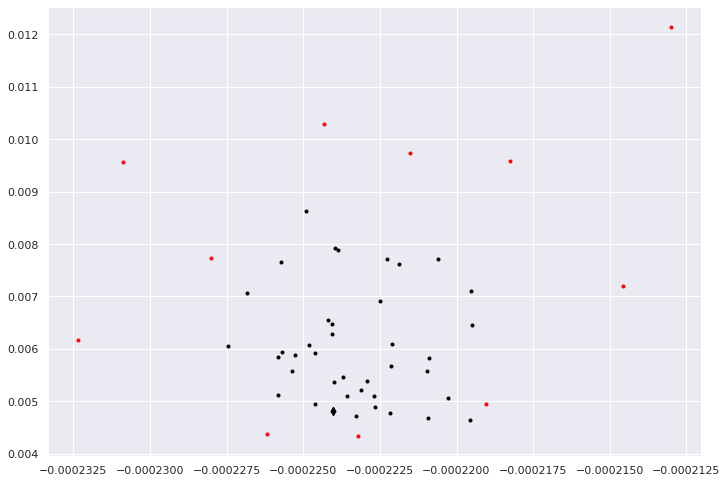

-------------------
Thermococcus
43 Thermococcus
Adjusted Rand Index: -0.026399413346370082
fowlkes_mallows_score: 0.7734309162699123
homogeneity_completeness_v_measure: 0.05512581036683671 0.009751076938919133 0.0165709558682727


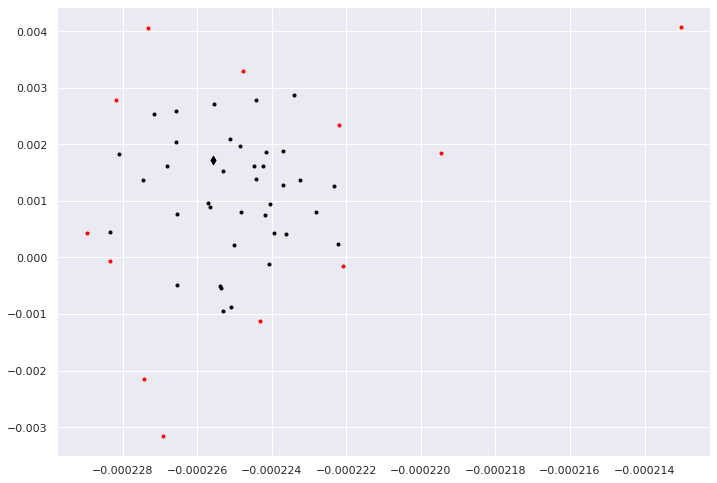

-------------------
Thermoplasma
44 Thermoplasma
Adjusted Rand Index: 0.08579809337570277
fowlkes_mallows_score: 0.8005864881025361
homogeneity_completeness_v_measure: 0.3006782061690191 0.0531862715976349 0.09038461751077799


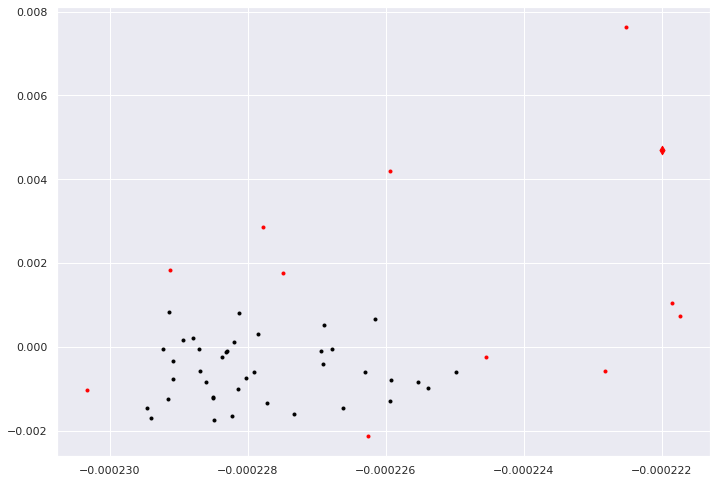

-------------------
Thermotoga
45 Thermotoga
Adjusted Rand Index: 0.10054557302203161
fowlkes_mallows_score: 0.817831943928969
homogeneity_completeness_v_measure: 0.3191738423312055 0.05907845268009472 0.09970221986531402


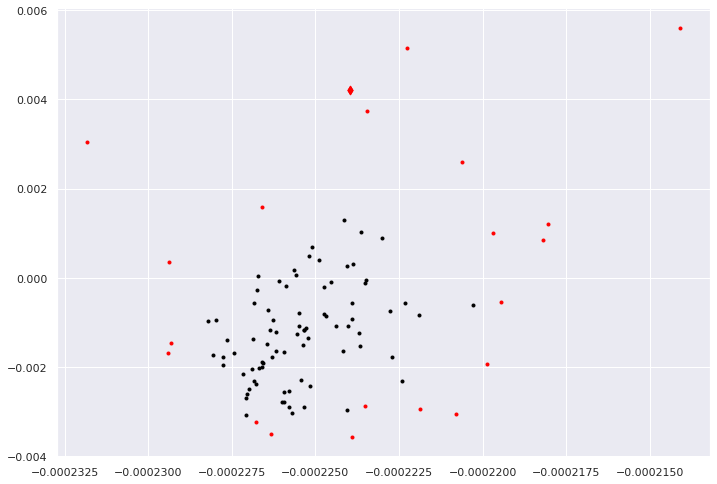

-------------------
Thermus
46 Thermus
Adjusted Rand Index: 0.21032806885379235
fowlkes_mallows_score: 0.84797414874558
homogeneity_completeness_v_measure: 0.39996022111711504 0.12213450627226725 0.18712674758829256


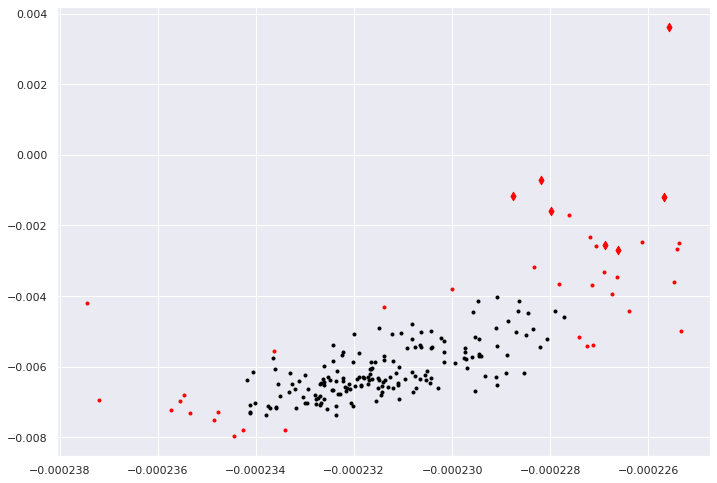

-------------------
Xanthomonas
47 Xanthomonas
Adjusted Rand Index: 0.24057777422404508
fowlkes_mallows_score: 0.8645870277797622
homogeneity_completeness_v_measure: 0.30863409602709524 0.1129738191703757 0.16540283660493565


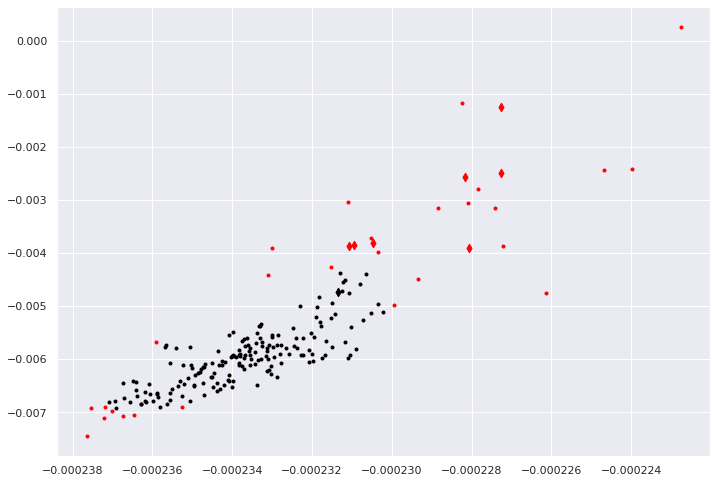

In [ ]:
from sklearn.ensemble import IsolationForest


# params for dbscan
values = []
familyes = sorted(set(family_lables))
print(familyes)
for i in familyes:    
  df1= df.query('y==@i')
  df_data1 = df_data.query('family_lable==@i')
  true_labels = df_data1.is_RE.tolist()
# print(len(familyes))
  # values.append({'n_clusters':2})
clustering_function(familyes,df_data, df, IsolationForest, params=None)

# one class svm 

['Aeropyrum', 'Agmenellum', 'Agrobacterium', 'Anabaena', 'Arthrobacter', 'Arthrospira', 'Bacillus', 'Bacteroides', 'Bifidobacterium', 'Brevibacterium', 'Chlorella', 'Chlorobium', 'Citrobacter', 'Clostridium', 'Corynebacterium', 'Deinococcus', 'Desulfovibrio', 'Diplococcus', 'Enterobacter', 'Escherichia', 'Eubacterium', 'Fischerella', 'Flavobacterium', 'Frankia', 'Haemophilus', 'Helicobacter', 'Klebsiella', 'Lactococcus', 'Methanocaldococcus', 'Methylococcus', 'Moraxella', 'Mycoplasma', 'Neisseria', 'Nocardia', 'Pseudomonas', 'Pyrococcus', 'Rhodobacter', 'Salmonella', 'Shewanella', 'Sphaerotilus', 'Streptococcus', 'Streptomyces', 'Sulfolobus', 'Thermococcus', 'Thermoplasma', 'Thermotoga', 'Thermus', 'Xanthomonas']
-------------------
Aeropyrum
0 Aeropyrum
Adjusted Rand Index: -0.0015105740181268882
fowlkes_mallows_score: 0.6857142857142857
homogeneity_completeness_v_measure: 0.1388355548458186 0.019335853523214326 0.033944237836583804


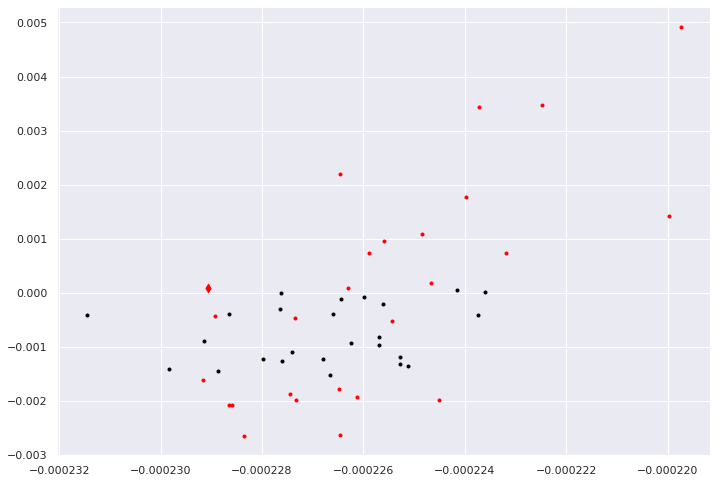

-------------------
Agmenellum
1 Agmenellum
Adjusted Rand Index: -0.0015105740181268882
fowlkes_mallows_score: 0.6857142857142857
homogeneity_completeness_v_measure: 0.1388355548458186 0.019335853523214326 0.033944237836583804


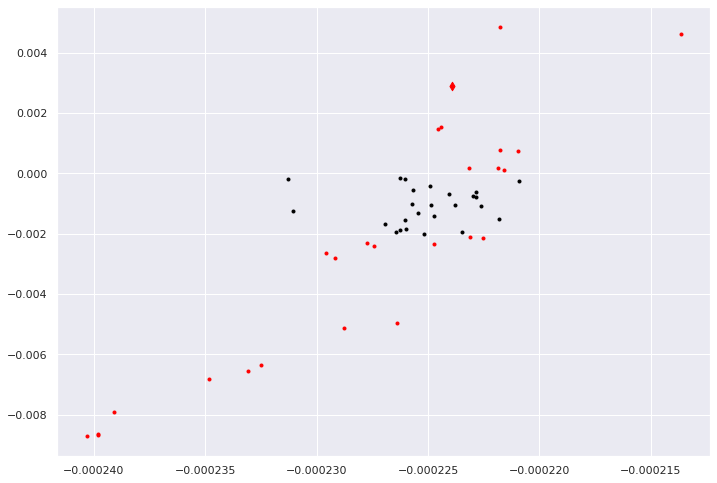

-------------------
Agrobacterium
2 Agrobacterium
Adjusted Rand Index: 0.0049081985093619345
fowlkes_mallows_score: 0.6891839007912093
homogeneity_completeness_v_measure: 0.1554324907626066 0.02169551538314924 0.03807628243278946


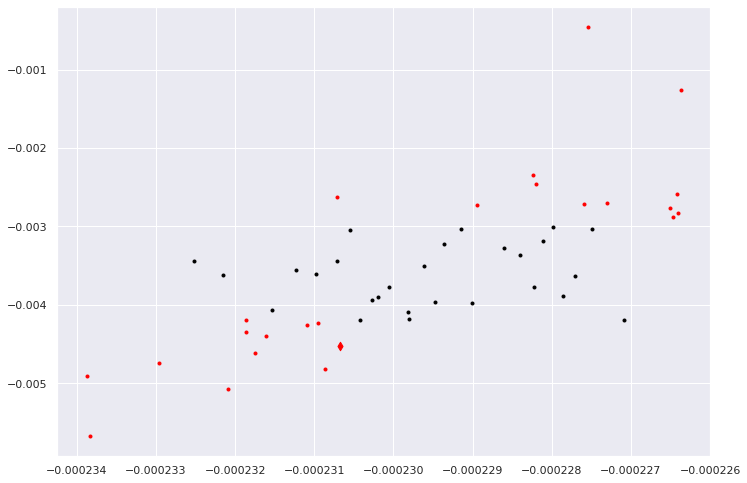

-------------------
Anabaena
3 Anabaena
Adjusted Rand Index: 0.006219327757029538
fowlkes_mallows_score: 0.6525022327591361
homogeneity_completeness_v_measure: 0.04533153211315304 0.017286000841692958 0.025028162729702423


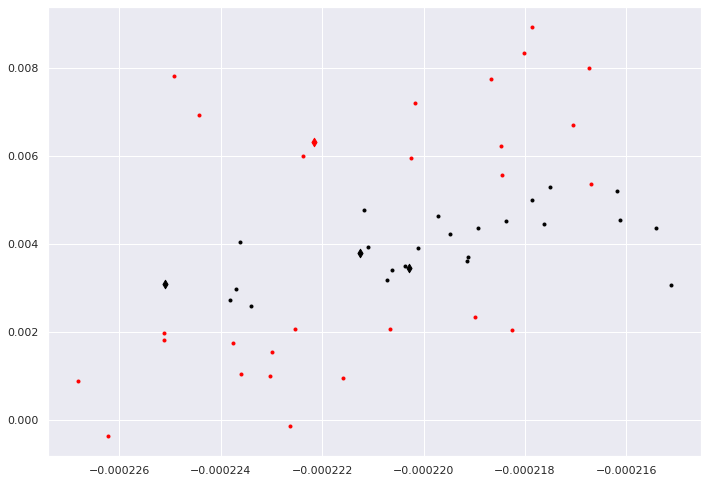

-------------------
Arthrobacter
4 Arthrobacter
Adjusted Rand Index: 0.00340642743958801
fowlkes_mallows_score: 0.6879162727700022
homogeneity_completeness_v_measure: 0.15523438183024274 0.026980118808811848 0.04597045844654071


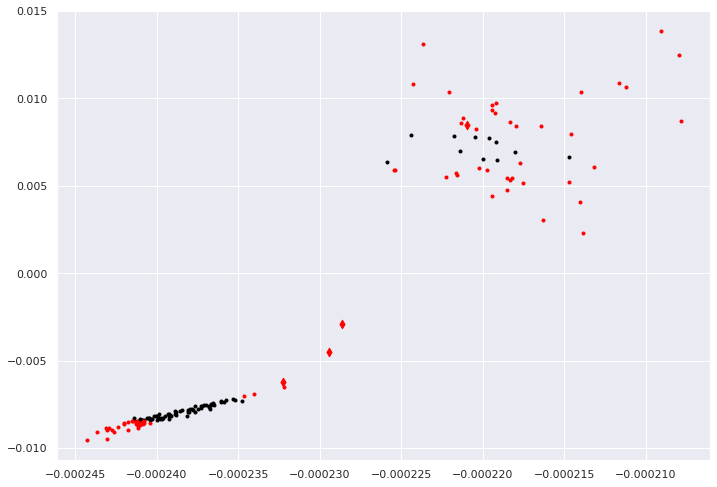

-------------------
Arthrospira
5 Arthrospira
Adjusted Rand Index: -0.007008349076726187
fowlkes_mallows_score: 0.6869960098706456
homogeneity_completeness_v_measure: 0.12349276823204665 0.017314509387138553 0.030370826436689265


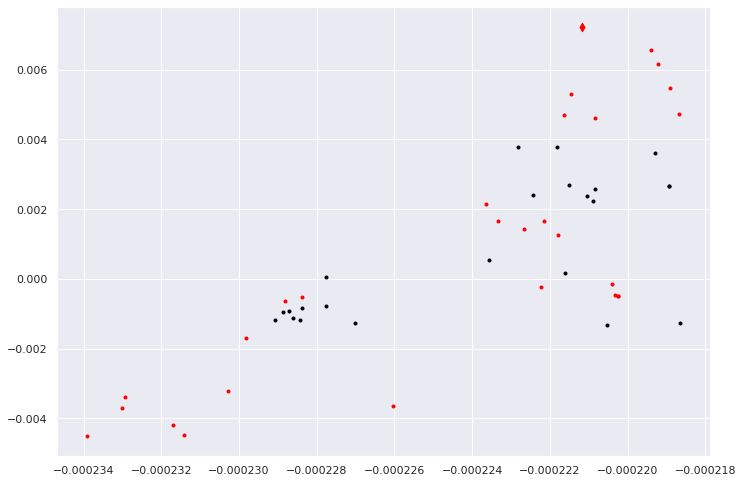

-------------------
Bacillus
6 Bacillus
Adjusted Rand Index: 0.019185071822997966
fowlkes_mallows_score: 0.643740570275555
homogeneity_completeness_v_measure: 0.08284372956945525 0.04024425108263183 0.05417237062062854


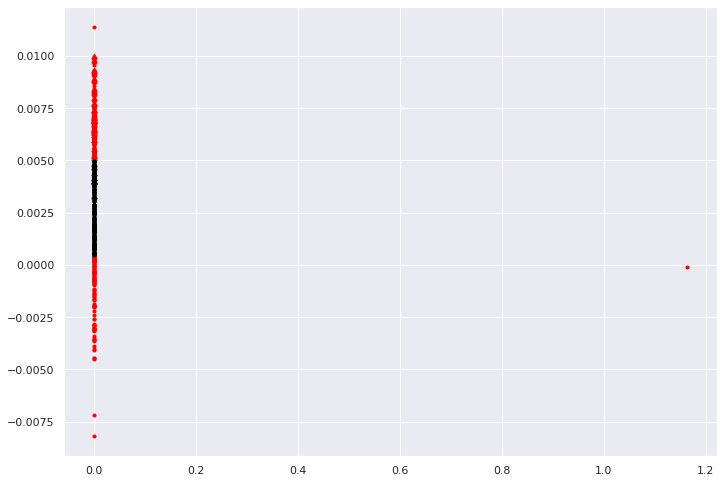

-------------------
Bacteroides
7 Bacteroides
Adjusted Rand Index: 0.003025366534791715
fowlkes_mallows_score: 0.6743643102871643
homogeneity_completeness_v_measure: 0.1682513330031832 0.03957160000461408 0.06407352984086015


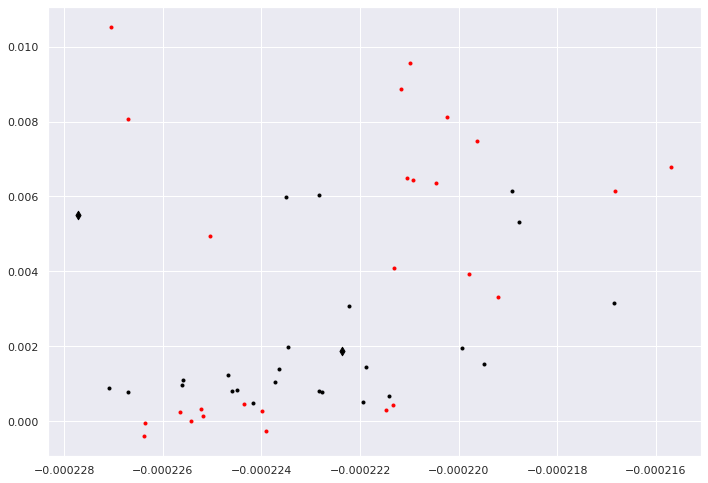

-------------------
Bifidobacterium
8 Bifidobacterium
Adjusted Rand Index: -0.001099481044946785
fowlkes_mallows_score: 0.682871474172461
homogeneity_completeness_v_measure: 0.01216763411343253 0.0023118951955915417 0.003885526144973343


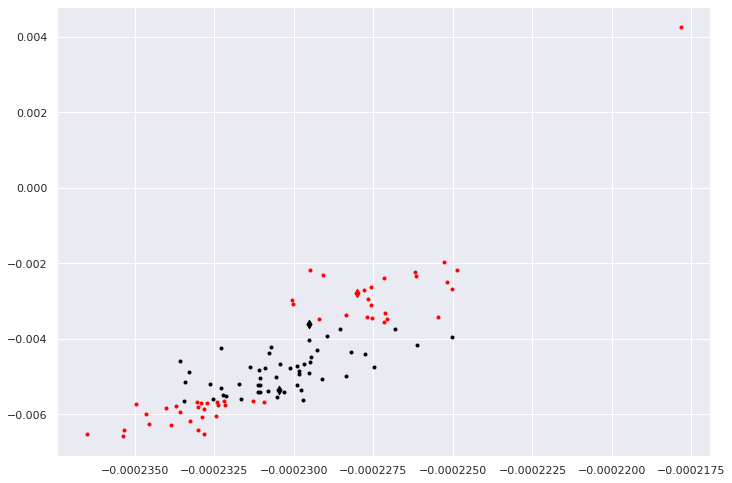

-------------------
Brevibacterium
9 Brevibacterium
Adjusted Rand Index: -0.0015105740181268882
fowlkes_mallows_score: 0.6857142857142857
homogeneity_completeness_v_measure: 0.1388355548458186 0.019335853523214326 0.033944237836583804


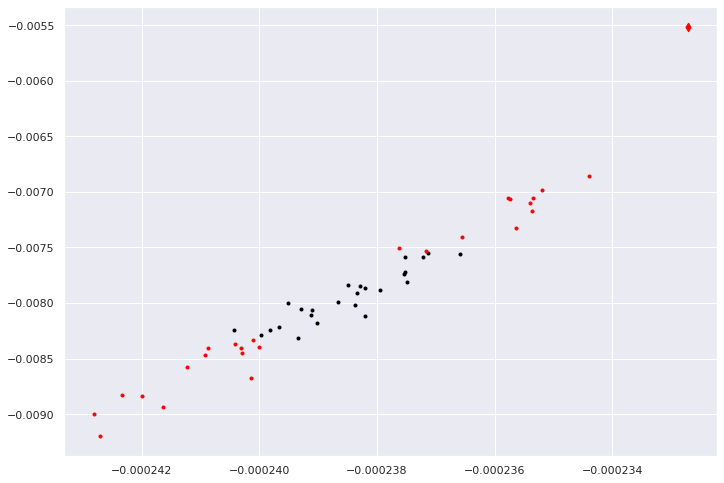

-------------------
Chlorella
10 Chlorella
Adjusted Rand Index: -0.003676203835828476
fowlkes_mallows_score: 0.6500417445503085
homogeneity_completeness_v_measure: 0.184047942863609 0.07039130033490261 0.10183471589738702


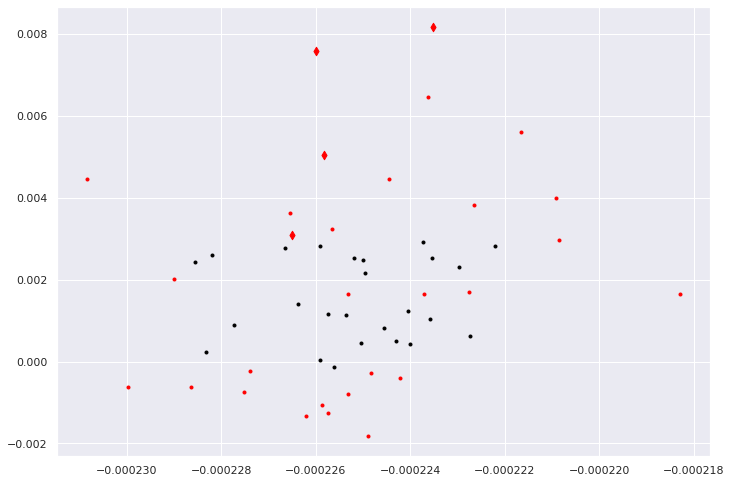

-------------------
Chlorobium
11 Chlorobium
Adjusted Rand Index: -0.0007322832292195953
fowlkes_mallows_score: 0.6896704506581811
homogeneity_completeness_v_measure: 3.984530812763793e-05 5.549320866682484e-06 9.741874963214668e-06


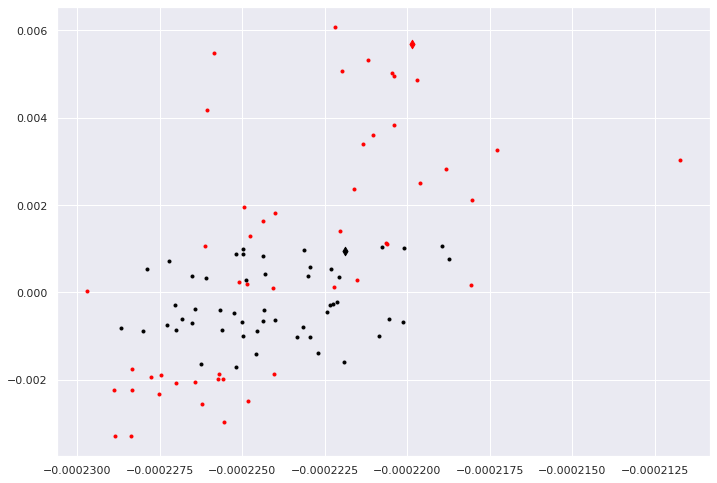

-------------------
Citrobacter
12 Citrobacter
Adjusted Rand Index: 0.02056617469150738
fowlkes_mallows_score: 0.6470995952589369
homogeneity_completeness_v_measure: 0.21586504084499003 0.09489466505068185 0.1318345999079695


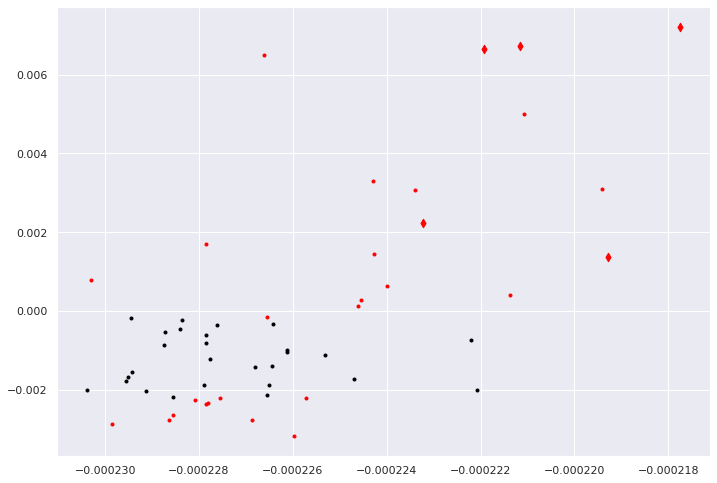

-------------------
Clostridium
13 Clostridium
Adjusted Rand Index: 0.0007056318499933976
fowlkes_mallows_score: 0.6869273544982754
homogeneity_completeness_v_measure: 0.03038239664520709 0.0052805355457951515 0.008997315453042935


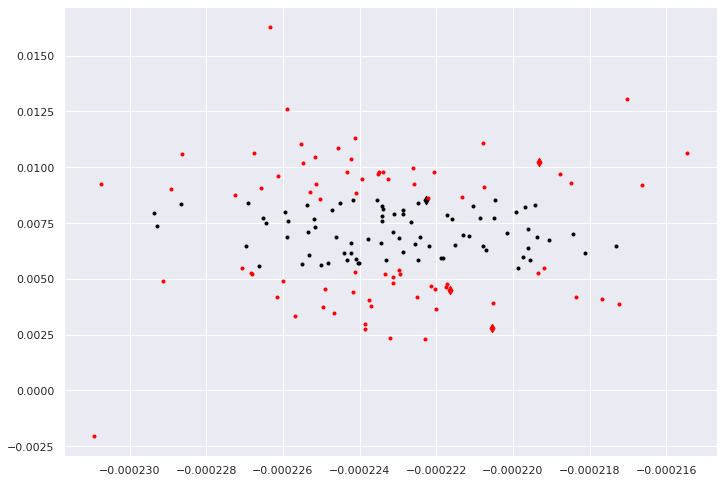

-------------------
Corynebacterium
14 Corynebacterium
Adjusted Rand Index: 0.0049081985093619345
fowlkes_mallows_score: 0.6891839007912093
homogeneity_completeness_v_measure: 0.1554324907626066 0.02169551538314924 0.03807628243278946


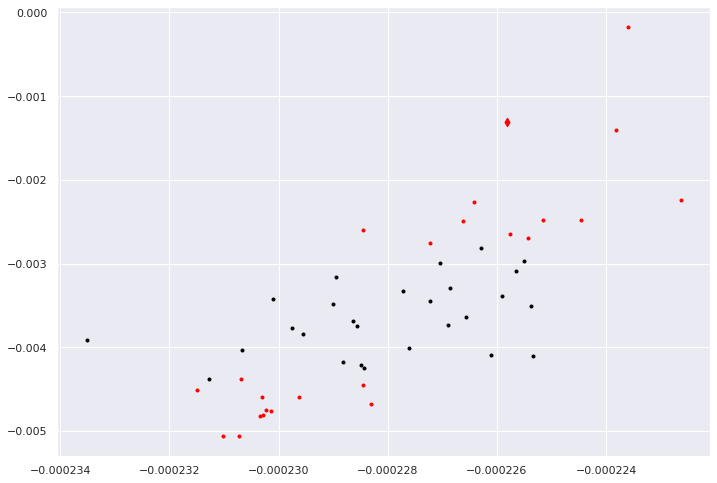

-------------------
Deinococcus
15 Deinococcus
Adjusted Rand Index: -0.0015105740181268882
fowlkes_mallows_score: 0.6857142857142857
homogeneity_completeness_v_measure: 0.1388355548458186 0.019335853523214326 0.033944237836583804


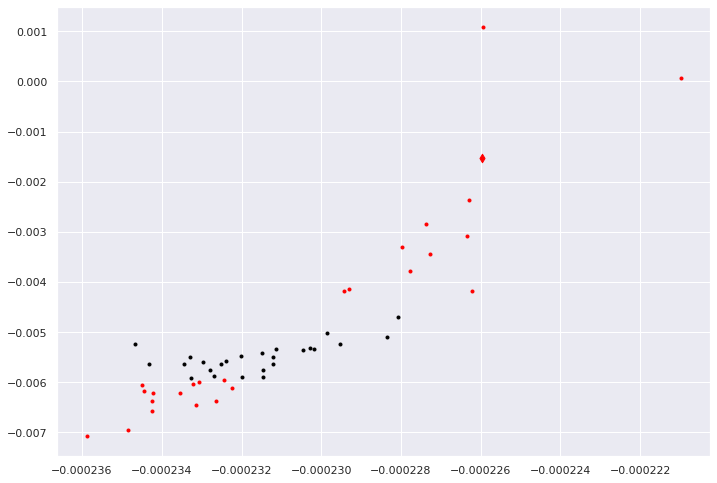

-------------------
Desulfovibrio
16 Desulfovibrio
Adjusted Rand Index: 0.0007771398966099176
fowlkes_mallows_score: 0.6900871053637038
homogeneity_completeness_v_measure: 0.1428594048435671 0.0198907433795962 0.03491953515407994


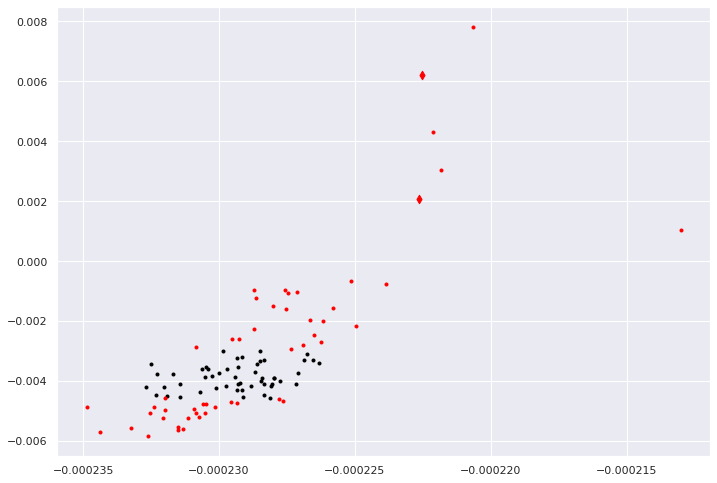

-------------------
Diplococcus
17 Diplococcus
Adjusted Rand Index: -0.0015105740181268882
fowlkes_mallows_score: 0.6857142857142857
homogeneity_completeness_v_measure: 0.1388355548458186 0.019335853523214326 0.033944237836583804


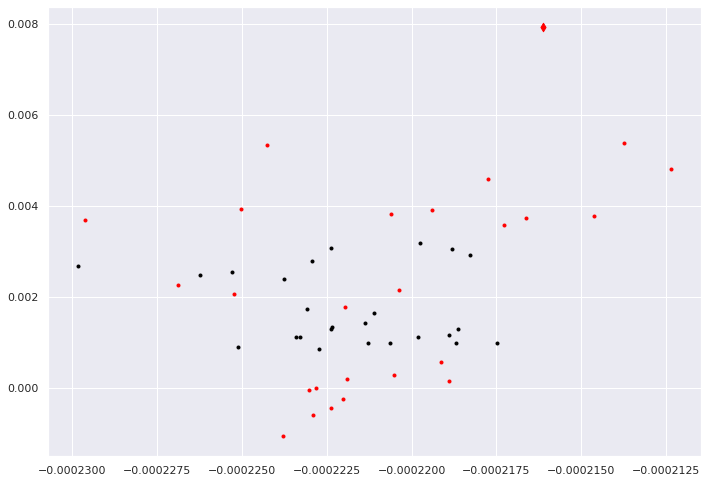

-------------------
Enterobacter
18 Enterobacter
Adjusted Rand Index: 0.033873699491894504
fowlkes_mallows_score: 0.6523691359369412
homogeneity_completeness_v_measure: 0.2278434404710406 0.10016039133923603 0.13915013148296004


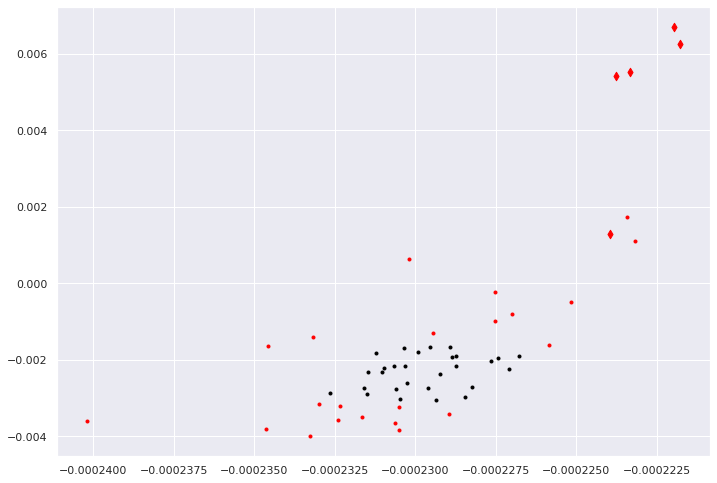

-------------------
Escherichia
19 Escherichia
Adjusted Rand Index: 0.0016163616362935423
fowlkes_mallows_score: 0.670155398514935
homogeneity_completeness_v_measure: 0.05619591257364568 0.016602039232479295 0.02563167567508803


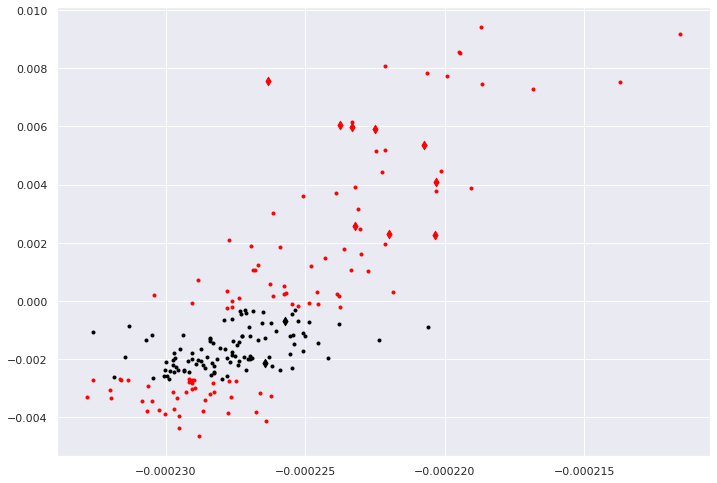

-------------------
Eubacterium
20 Eubacterium
Adjusted Rand Index: -0.004362843119432831
fowlkes_mallows_score: 0.6857608019462199
homogeneity_completeness_v_measure: 0.13101934947788751 0.01828789011963489 0.03209579754145304


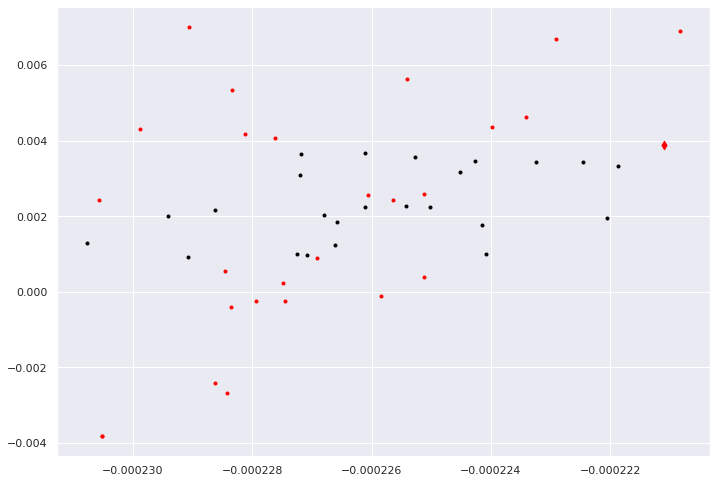

-------------------
Fischerella
21 Fischerella
Adjusted Rand Index: -0.0015105740181268882
fowlkes_mallows_score: 0.6857142857142857
homogeneity_completeness_v_measure: 0.1388355548458186 0.019335853523214326 0.033944237836583804


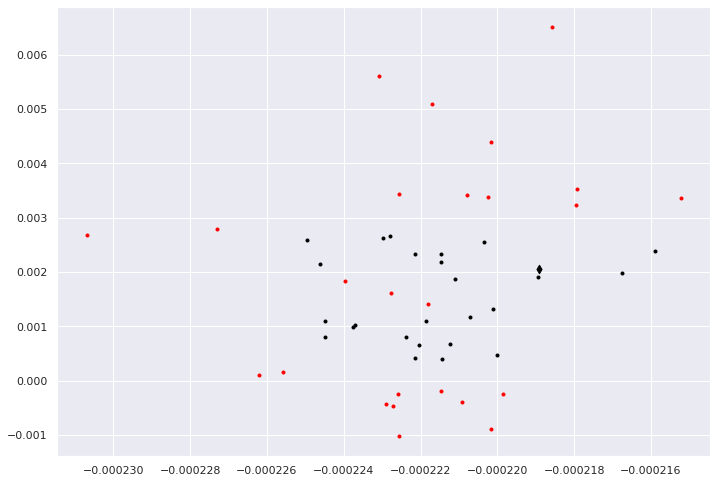

-------------------
Flavobacterium
22 Flavobacterium
Adjusted Rand Index: 0.003025366534791715
fowlkes_mallows_score: 0.6743643102871643
homogeneity_completeness_v_measure: 0.1682513330031832 0.03957160000461408 0.06407352984086015


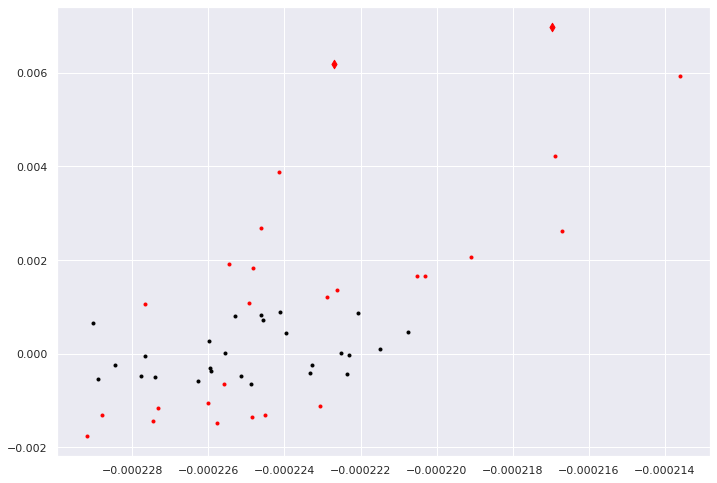

-------------------
Frankia
23 Frankia
Adjusted Rand Index: 0.0015709969788519637
fowlkes_mallows_score: 0.6868571428571428
homogeneity_completeness_v_measure: 0.1469645721288326 0.020467994981118183 0.03593172077161986


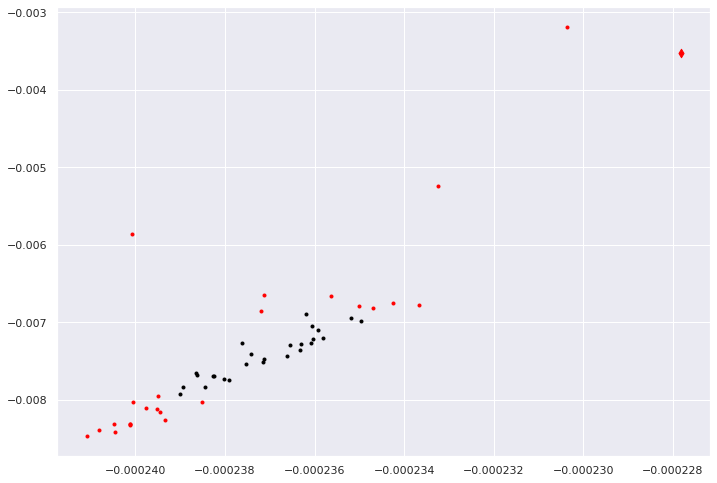

-------------------
Haemophilus
24 Haemophilus
Adjusted Rand Index: 0.020278401283615972
fowlkes_mallows_score: 0.6622350705568112
homogeneity_completeness_v_measure: 0.2056805345652218 0.07835329738868076 0.11347766553716158


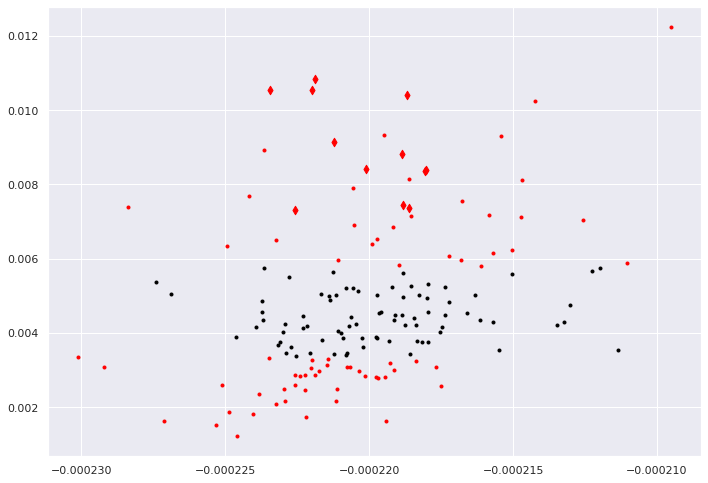

-------------------
Helicobacter
25 Helicobacter
Adjusted Rand Index: 0.003399142118262776
fowlkes_mallows_score: 0.6888127538500617
homogeneity_completeness_v_measure: 0.15506812783764654 0.02758679361751137 0.04684059323702636


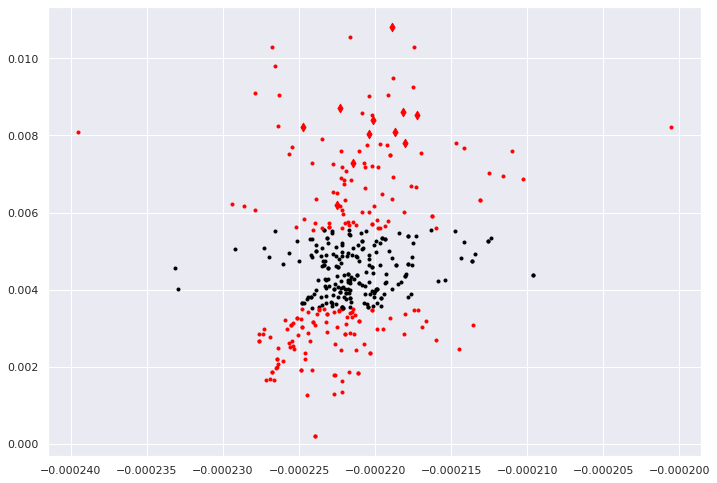

-------------------
Klebsiella
26 Klebsiella
Adjusted Rand Index: 0.0007771398966099176
fowlkes_mallows_score: 0.6900871053637038
homogeneity_completeness_v_measure: 0.1428594048435671 0.0198907433795962 0.03491953515407994


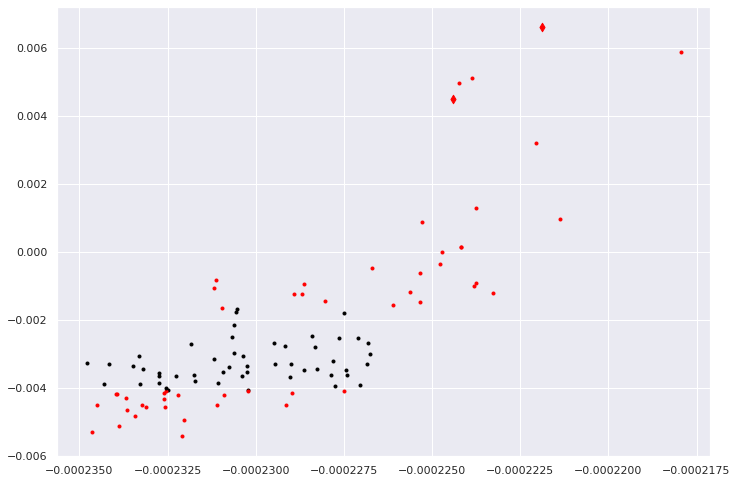

-------------------
Lactococcus
27 Lactococcus
Adjusted Rand Index: -0.0002788245994109277
fowlkes_mallows_score: 0.6424748491506089
homogeneity_completeness_v_measure: 0.02460901281309377 0.010818166846216625 0.015029387554578673


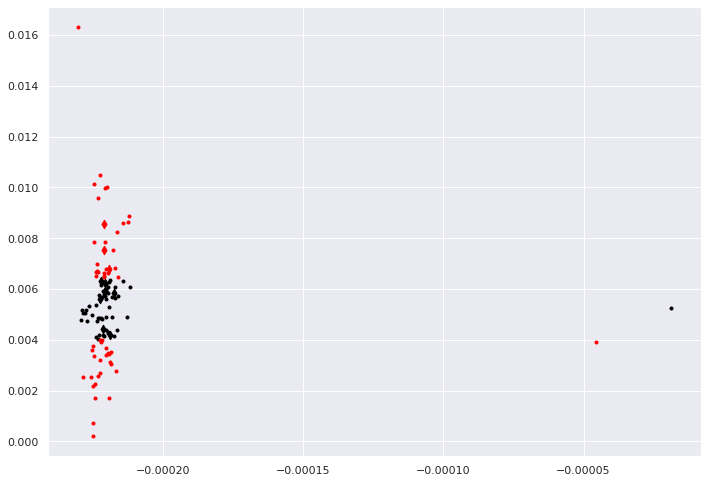

-------------------
Methanocaldococcus
28 Methanocaldococcus
Adjusted Rand Index: 0.0019356399709654004
fowlkes_mallows_score: 0.6397222383097309
homogeneity_completeness_v_measure: 0.059364005849429184 0.026096525074634586 0.03625519875501181


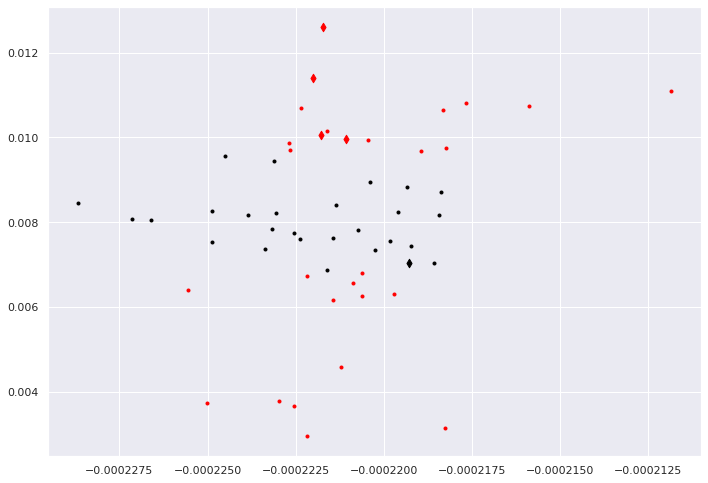

-------------------
Methylococcus
29 Methylococcus
Adjusted Rand Index: -0.0015105740181268882
fowlkes_mallows_score: 0.6857142857142857
homogeneity_completeness_v_measure: 0.1388355548458186 0.019335853523214326 0.033944237836583804


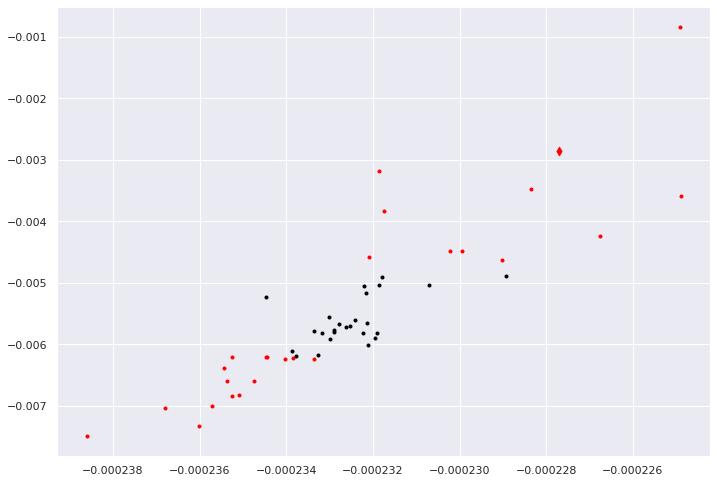

-------------------
Moraxella
30 Moraxella
Adjusted Rand Index: 0.028303342695762214
fowlkes_mallows_score: 0.6611019326966535
homogeneity_completeness_v_measure: 0.21715781716491048 0.08280748598840491 0.11989581937058223


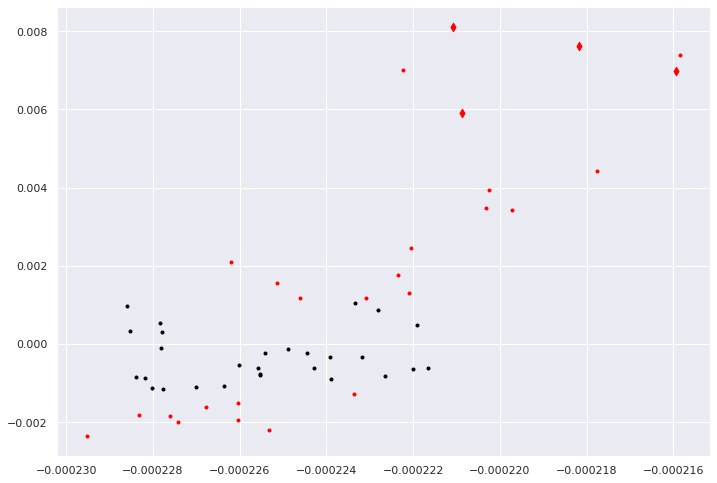

-------------------
Mycoplasma
31 Mycoplasma
Adjusted Rand Index: 0.003025366534791715
fowlkes_mallows_score: 0.6743643102871643
homogeneity_completeness_v_measure: 0.1682513330031832 0.03957160000461408 0.06407352984086015


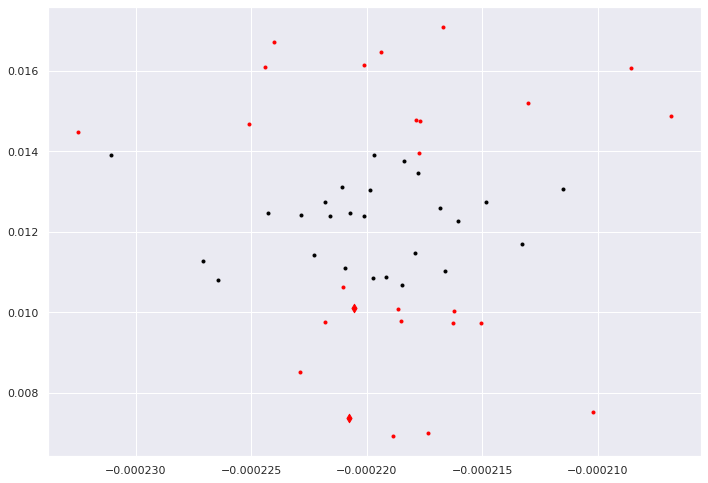

-------------------
Neisseria
32 Neisseria
Adjusted Rand Index: 0.015129423732150572
fowlkes_mallows_score: 0.6656711910857449
homogeneity_completeness_v_measure: 0.19671203476884916 0.06988489134664498 0.1031309653618659


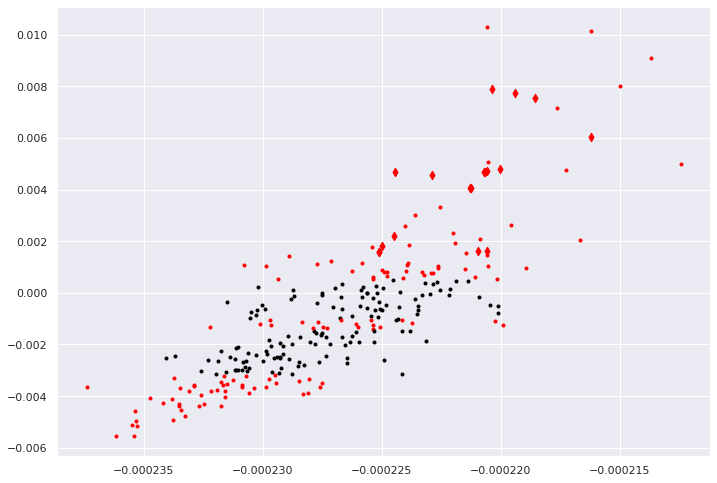

-------------------
Nocardia
33 Nocardia
Adjusted Rand Index: 0.0011654499076435923
fowlkes_mallows_score: 0.683707302170224
homogeneity_completeness_v_measure: 0.15441999878924076 0.02934036723786607 0.049311389297938386


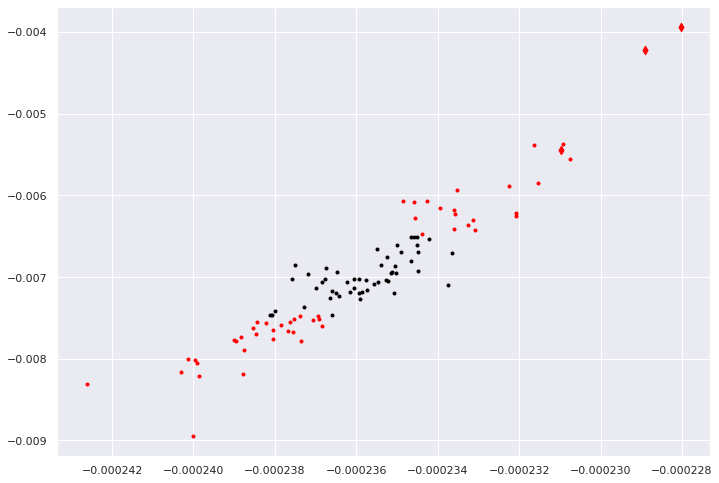

-------------------
Pseudomonas
34 Pseudomonas
Adjusted Rand Index: -0.0048226797123368005
fowlkes_mallows_score: 0.6482023827903773
homogeneity_completeness_v_measure: 0.00020795312530768855 7.929751613355203e-05 0.0001148137823217512


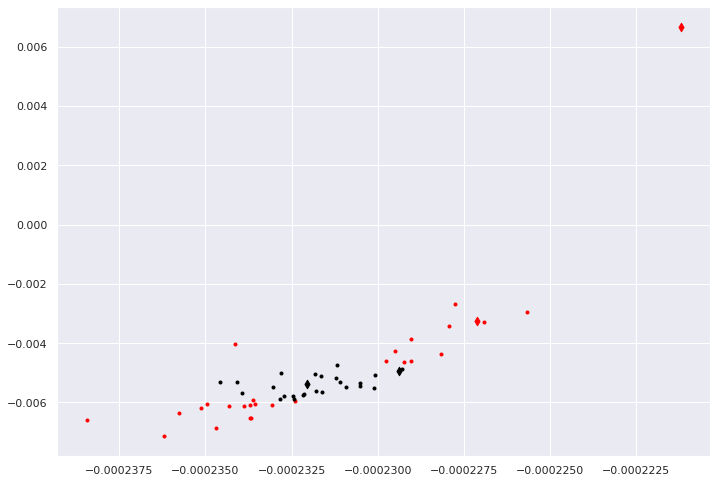

-------------------
Pyrococcus
35 Pyrococcus
Adjusted Rand Index: 0.0034303808602339694
fowlkes_mallows_score: 0.6845431301679872
homogeneity_completeness_v_measure: 0.1588448730374049 0.030181109605696983 0.050724397317342976


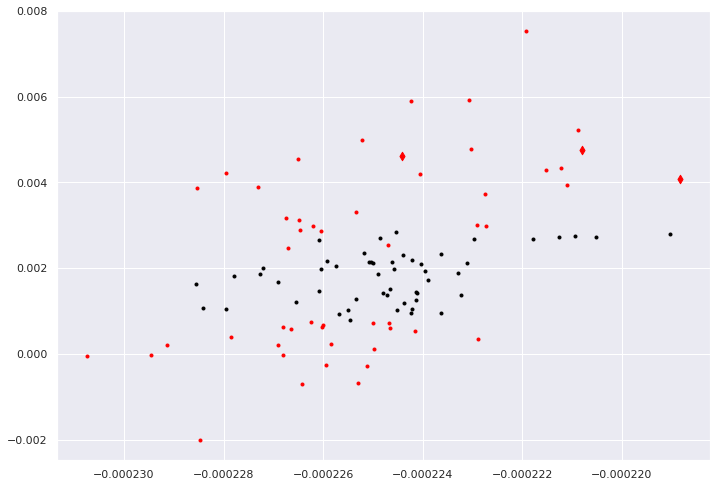

-------------------
Rhodobacter
36 Rhodobacter
Adjusted Rand Index: 0.0015709969788519637
fowlkes_mallows_score: 0.6868571428571428
homogeneity_completeness_v_measure: 0.1469645721288326 0.020467994981118183 0.03593172077161986


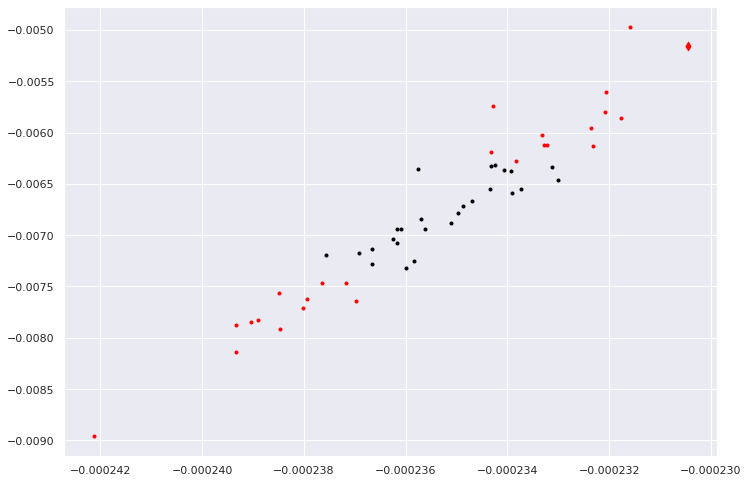

-------------------
Salmonella
37 Salmonella
Adjusted Rand Index: 0.0044874007594062825
fowlkes_mallows_score: 0.6785513179854324
homogeneity_completeness_v_measure: 0.16825133300318107 0.039571600004613385 0.0640735298408591


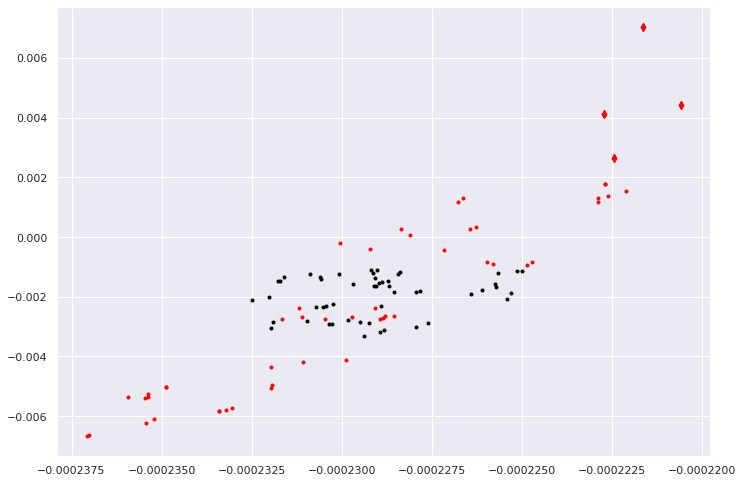

-------------------
Shewanella
38 Shewanella
Adjusted Rand Index: 0.0015709969788519637
fowlkes_mallows_score: 0.6868571428571428
homogeneity_completeness_v_measure: 0.1469645721288326 0.020467994981118183 0.03593172077161986


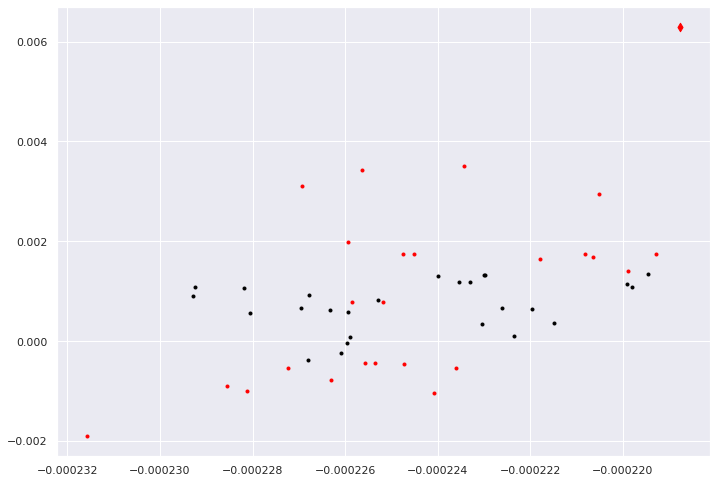

-------------------
Sphaerotilus
39 Sphaerotilus
Adjusted Rand Index: 0.0045336787564766836
fowlkes_mallows_score: 0.6629250151987521
homogeneity_completeness_v_measure: 0.18302646225521343 0.05745083081523058 0.08745126979331261


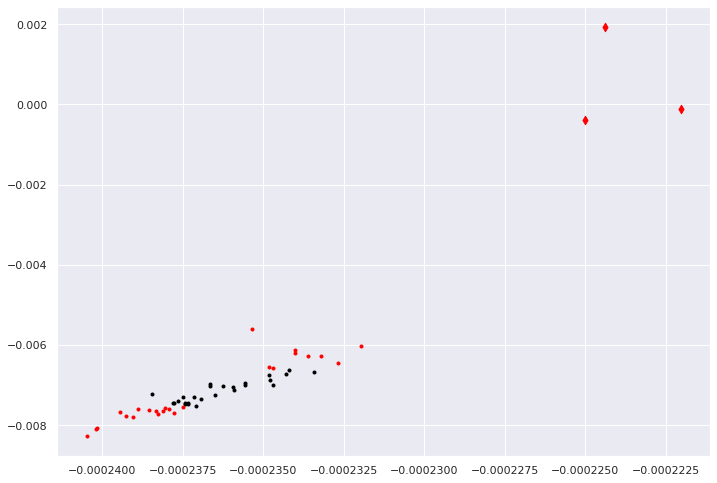

-------------------
Streptococcus
40 Streptococcus
Adjusted Rand Index: 0.01334717130407801
fowlkes_mallows_score: 0.6682600822881443
homogeneity_completeness_v_measure: 0.1924392068458906 0.06490966190960816 0.09707572382132736


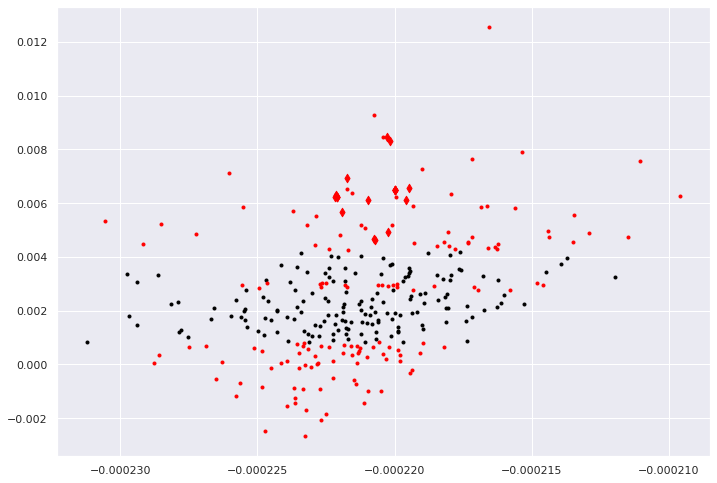

-------------------
Streptomyces
41 Streptomyces
Adjusted Rand Index: 0.005736849947846819
fowlkes_mallows_score: 0.6760956650321548
homogeneity_completeness_v_measure: 0.17365242017336877 0.04566104964187724 0.07230884436462556


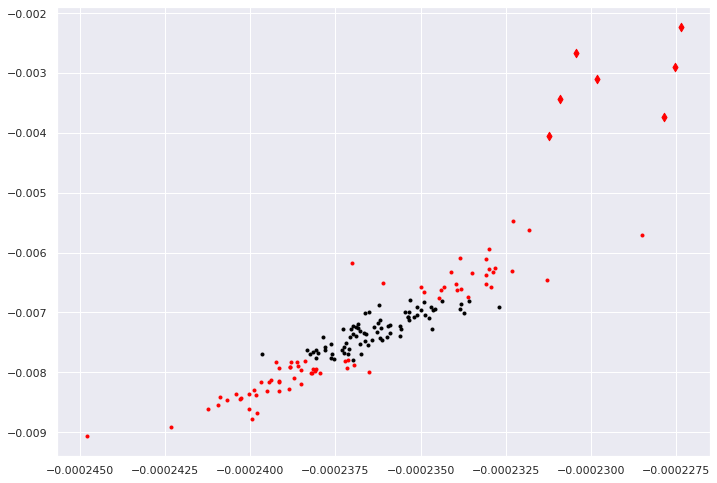

-------------------
Sulfolobus
42 Sulfolobus
Adjusted Rand Index: 0.0015709969788519637
fowlkes_mallows_score: 0.6868571428571428
homogeneity_completeness_v_measure: 0.1469645721288326 0.020467994981118183 0.03593172077161986


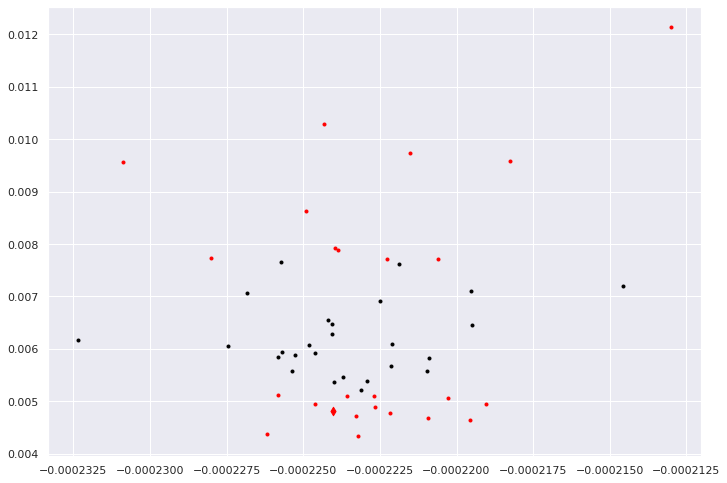

-------------------
Thermococcus
43 Thermococcus
Adjusted Rand Index: -0.004362843119432831
fowlkes_mallows_score: 0.6857608019462199
homogeneity_completeness_v_measure: 0.13101934947788751 0.01828789011963489 0.03209579754145304


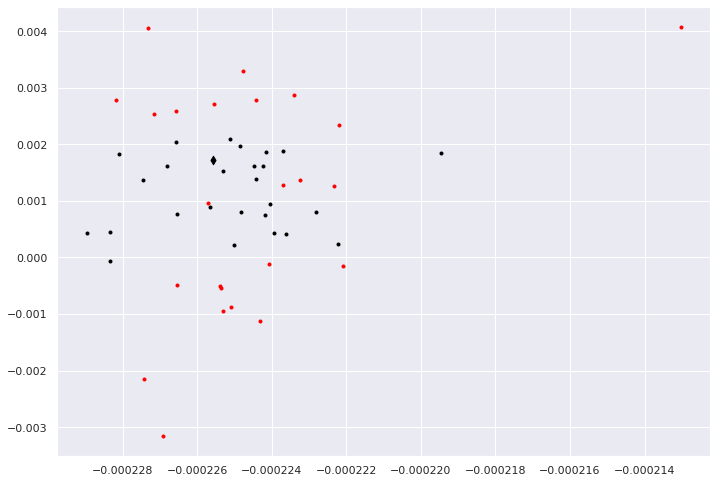

-------------------
Thermoplasma
44 Thermoplasma
Adjusted Rand Index: 0.0049081985093619345
fowlkes_mallows_score: 0.6891839007912093
homogeneity_completeness_v_measure: 0.1554324907626066 0.02169551538314924 0.03807628243278946


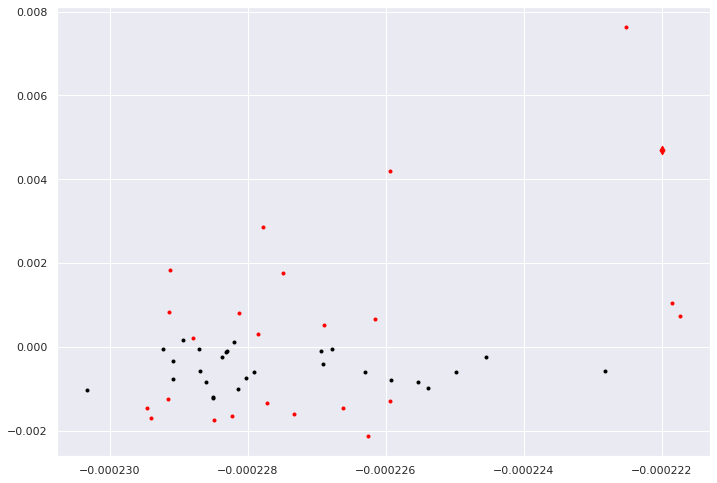

-------------------
Thermotoga
45 Thermotoga
Adjusted Rand Index: -0.0007322832292195953
fowlkes_mallows_score: 0.6896704506581811
homogeneity_completeness_v_measure: 0.13883555484580953 0.019335853523212897 0.03394423783658132


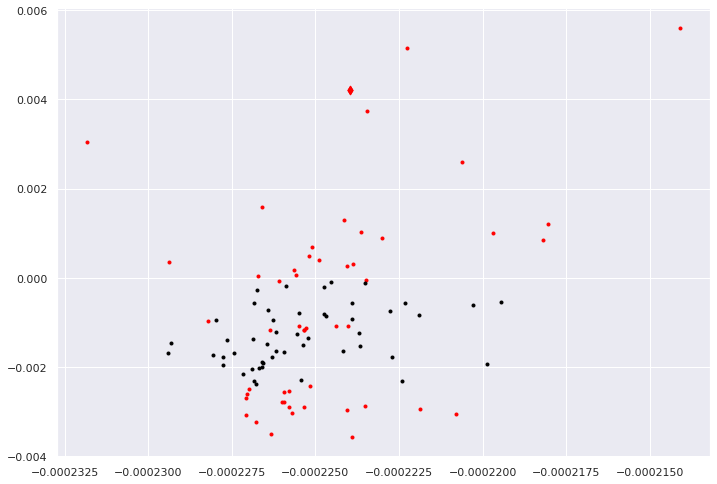

-------------------
Thermus
46 Thermus
Adjusted Rand Index: 0.003291540011119214
fowlkes_mallows_score: 0.683056228841494
homogeneity_completeness_v_measure: 0.1614893763771658 0.03442752282792292 0.056755483720390625


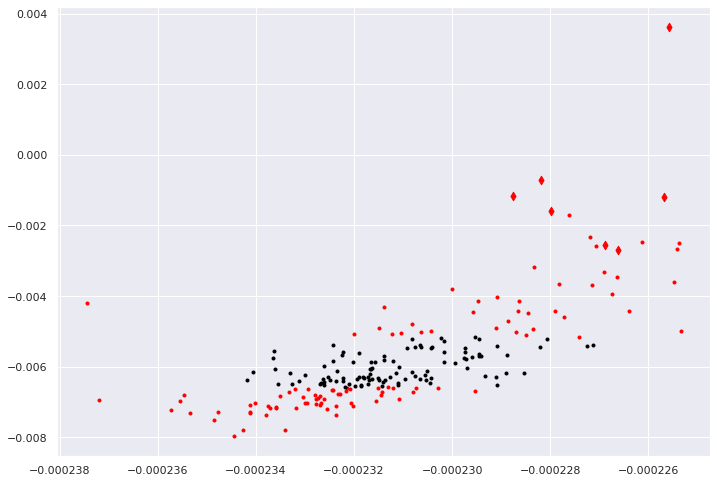

-------------------
Xanthomonas
47 Xanthomonas
Adjusted Rand Index: 0.005206247496996396
fowlkes_mallows_score: 0.6806031838197856
homogeneity_completeness_v_measure: 0.1682513330031776 0.03957160000461275 0.064073529840858


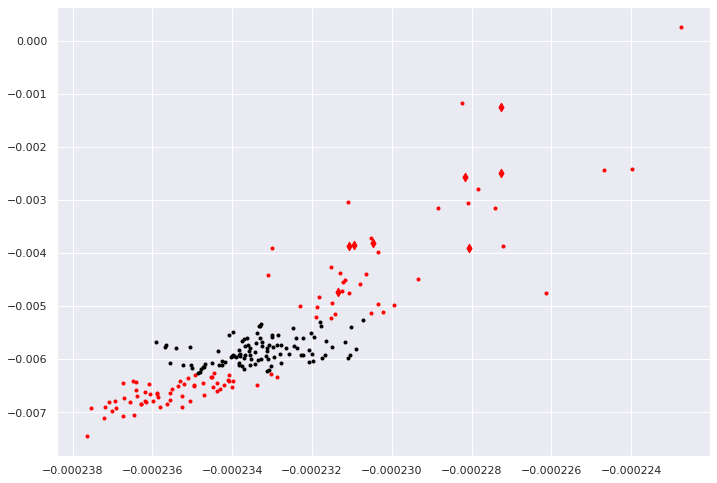

In [ ]:
from sklearn.svm import OneClassSVM



# params for dbscan
values = []
familyes = sorted(set(family_lables))
print(familyes)
for i in familyes:    
  df1= df.query('y==@i')
  df_data1 = df_data.query('family_lable==@i')
  true_labels = df_data1.is_RE.tolist()
# print(len(familyes))
  # values.append({'n_clusters':2})
clustering_function(familyes,df_data, df, OneClassSVM, params=None)



# EllipticEnvelope

['Aeropyrum', 'Agmenellum', 'Agrobacterium', 'Anabaena', 'Arthrobacter', 'Arthrospira', 'Bacillus', 'Bacteroides', 'Bifidobacterium', 'Brevibacterium', 'Chlorella', 'Chlorobium', 'Citrobacter', 'Clostridium', 'Corynebacterium', 'Deinococcus', 'Desulfovibrio', 'Diplococcus', 'Enterobacter', 'Escherichia', 'Eubacterium', 'Fischerella', 'Flavobacterium', 'Frankia', 'Haemophilus', 'Helicobacter', 'Klebsiella', 'Lactococcus', 'Methanocaldococcus', 'Methylococcus', 'Moraxella', 'Mycoplasma', 'Neisseria', 'Nocardia', 'Pseudomonas', 'Pyrococcus', 'Rhodobacter', 'Salmonella', 'Shewanella', 'Sphaerotilus', 'Streptococcus', 'Streptomyces', 'Sulfolobus', 'Thermococcus', 'Thermoplasma', 'Thermotoga', 'Thermus', 'Xanthomonas']
-------------------
Aeropyrum
0 Aeropyrum
Adjusted Rand Index: -0.030688622754491017
fowlkes_mallows_score: 0.8838403212710657
homogeneity_completeness_v_measure: 0.021183606185823278 0.006373772059346194 0.009799152591525005


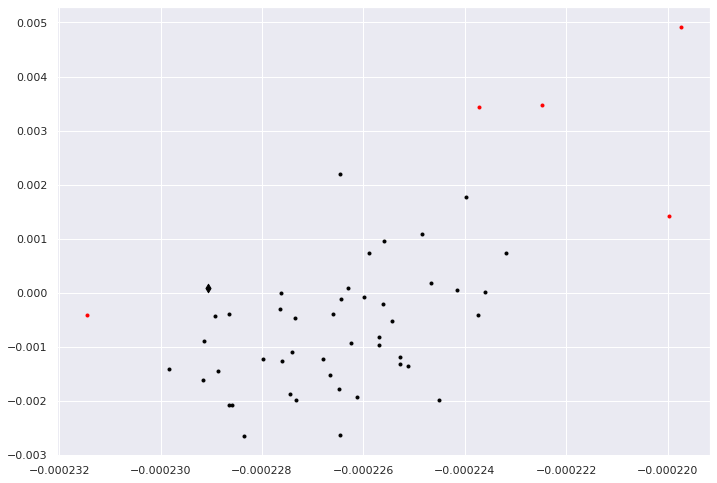

-------------------
Agmenellum
1 Agmenellum
Adjusted Rand Index: -0.030688622754491017
fowlkes_mallows_score: 0.8838403212710657
homogeneity_completeness_v_measure: 0.021183606185823278 0.006373772059346194 0.009799152591525005


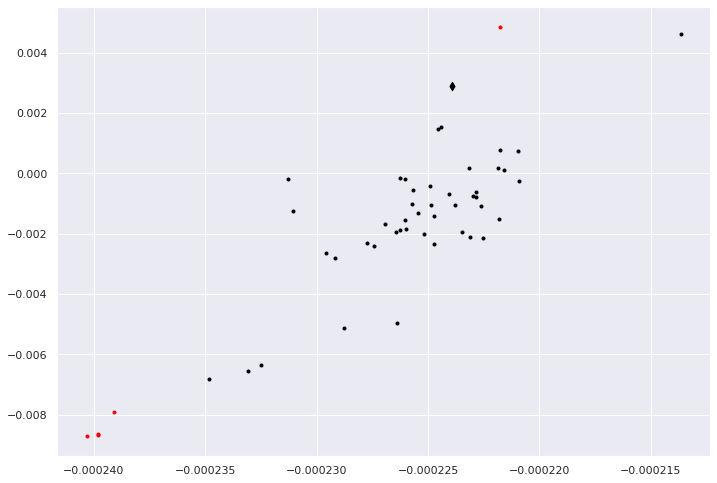

-------------------
Agrobacterium
2 Agrobacterium
Adjusted Rand Index: -0.030708661417322834
fowlkes_mallows_score: 0.8661085232276111
homogeneity_completeness_v_measure: 0.025698893821255796 0.006847325363367009 0.010813464167653667


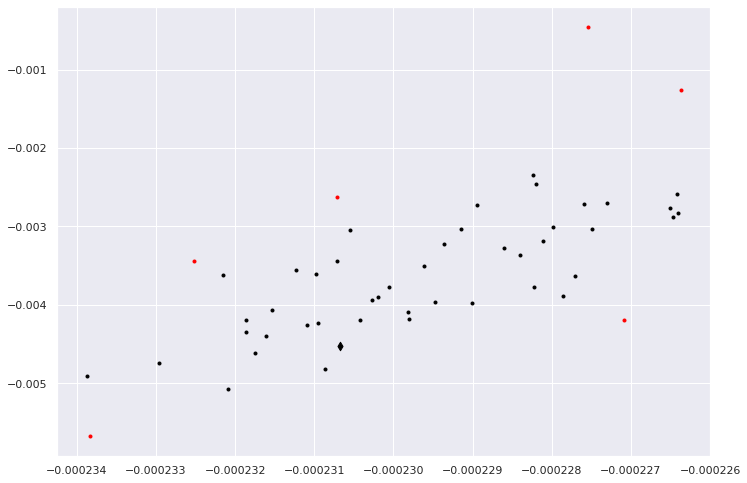

-------------------
Anabaena
3 Anabaena
Adjusted Rand Index: 0.09692554636374862
fowlkes_mallows_score: 0.8455684913311489
homogeneity_completeness_v_measure: 0.02338511480278485 0.017701603778546272 0.020150260271347444


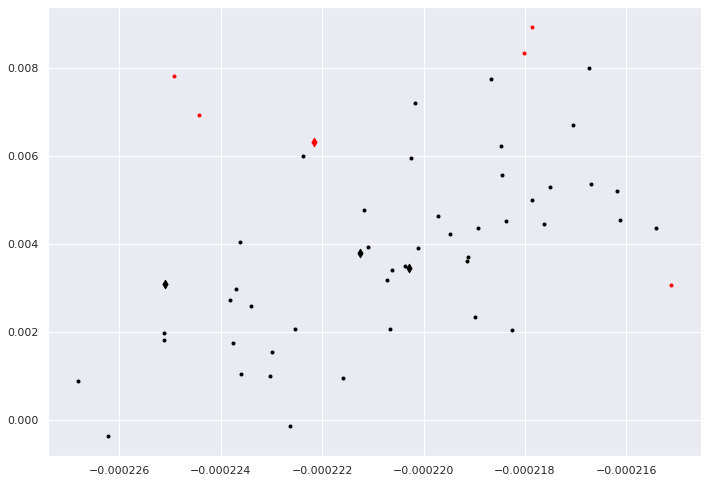

-------------------
Arthrobacter
4 Arthrobacter
Adjusted Rand Index: 0.05229984455554004
fowlkes_mallows_score: 0.88470627814606
homogeneity_completeness_v_measure: 0.019217340814863728 0.006939810480030431 0.010197188652675679


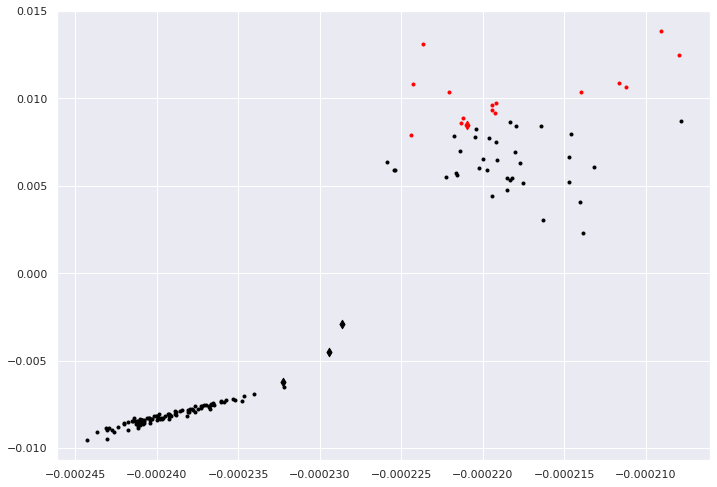

-------------------
Arthrospira
5 Arthrospira
Adjusted Rand Index: 0.3549973651853153
fowlkes_mallows_score: 0.9393911530907418
homogeneity_completeness_v_measure: 0.5429987341208927 0.19061535127803197 0.2821753194438662


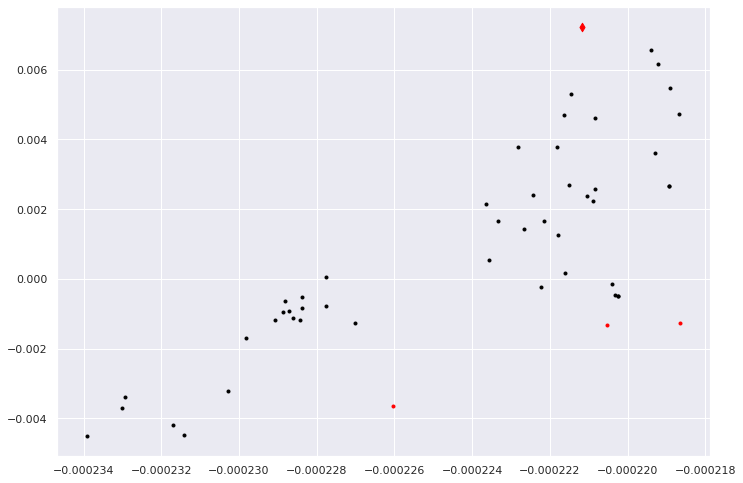

-------------------
Bacillus
6 Bacillus
Adjusted Rand Index: -0.023023816247040165
fowlkes_mallows_score: 0.809970887434106
homogeneity_completeness_v_measure: 0.001389048713787861 0.0014254104367106349 0.001406994685555845


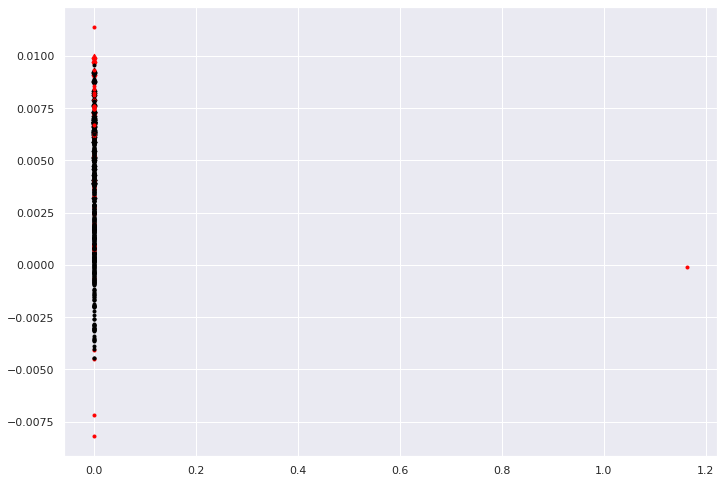

-------------------
Bacteroides
7 Bacteroides
Adjusted Rand Index: -0.05272274548013424
fowlkes_mallows_score: 0.8478815545719766
homogeneity_completeness_v_measure: 0.029533560624185776 0.013462814867927575 0.01849480820294072


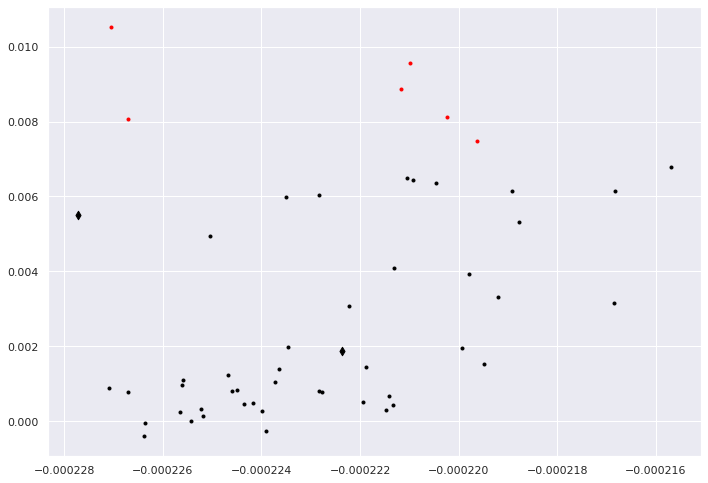

-------------------
Bifidobacterium
8 Bifidobacterium
Adjusted Rand Index: -0.04144995111966517
fowlkes_mallows_score: 0.8670807858659687
homogeneity_completeness_v_measure: 0.02537224732261839 0.00983421156412823 0.014174447298472554


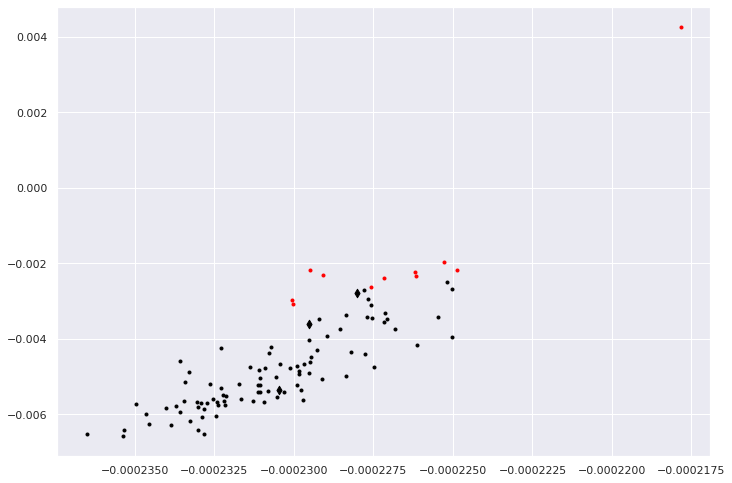

-------------------
Brevibacterium
9 Brevibacterium
Adjusted Rand Index: 0.2823353293413174
fowlkes_mallows_score: 0.9200777744431793
homogeneity_completeness_v_measure: 0.49166314964863234 0.1479327371530255 0.22743446912551735


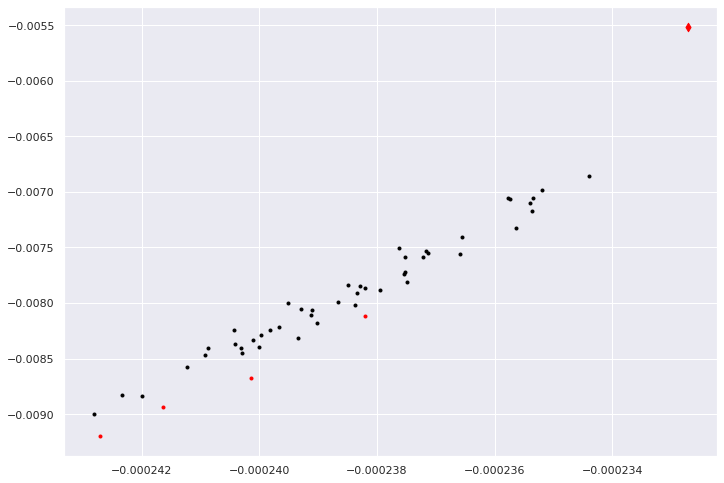

-------------------
Chlorella
10 Chlorella
Adjusted Rand Index: 0.2932460797629337
fowlkes_mallows_score: 0.8792900662596095
homogeneity_completeness_v_measure: 0.1490920873335172 0.11285679282532533 0.12846823244207764


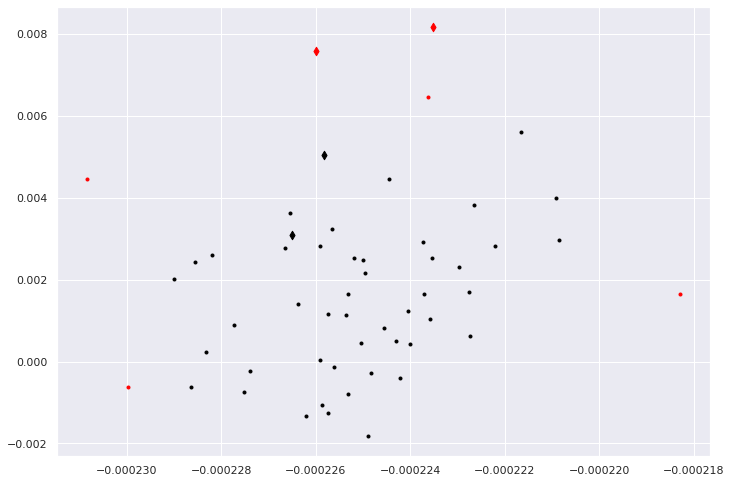

-------------------
Chlorobium
11 Chlorobium
Adjusted Rand Index: 0.10884986754986345
fowlkes_mallows_score: 0.8934793337539082
homogeneity_completeness_v_measure: 0.10032311958540002 0.028311665665171255 0.0441609105135304


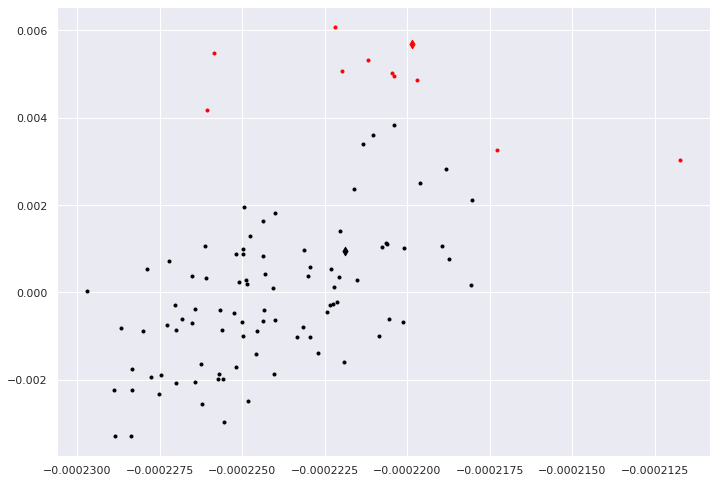

-------------------
Citrobacter
12 Citrobacter
Adjusted Rand Index: 0.4382149990920646
fowlkes_mallows_score: 0.8970972715858277
homogeneity_completeness_v_measure: 0.25306732386104097 0.2237118633928022 0.23748588066886883


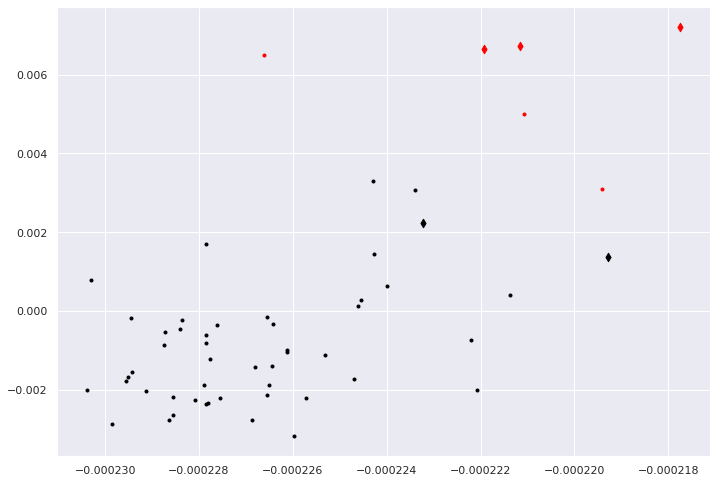

-------------------
Clostridium
13 Clostridium
Adjusted Rand Index: 0.05229984455554004
fowlkes_mallows_score: 0.88470627814606
homogeneity_completeness_v_measure: 0.019217340814863728 0.006939810480030431 0.010197188652675679


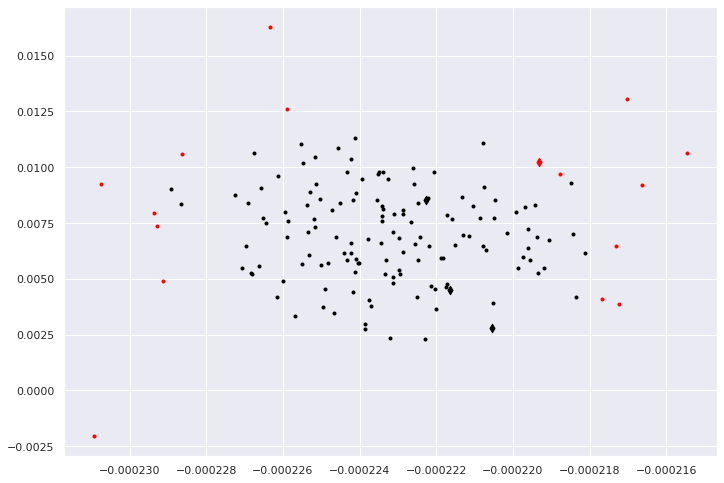

-------------------
Corynebacterium
14 Corynebacterium
Adjusted Rand Index: 0.23031496062992127
fowlkes_mallows_score: 0.9012575683950169
homogeneity_completeness_v_measure: 0.4507535814407424 0.12010075033949029 0.18966605081342153


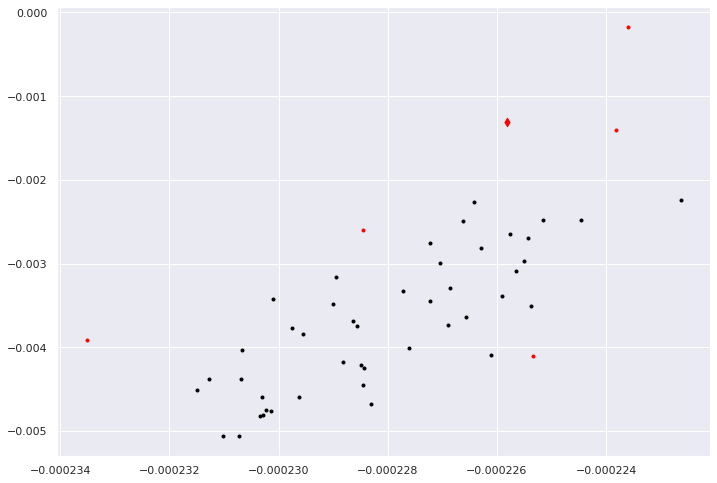

-------------------
Deinococcus
15 Deinococcus
Adjusted Rand Index: 0.2823353293413174
fowlkes_mallows_score: 0.9200777744431793
homogeneity_completeness_v_measure: 0.49166314964863234 0.1479327371530255 0.22743446912551735


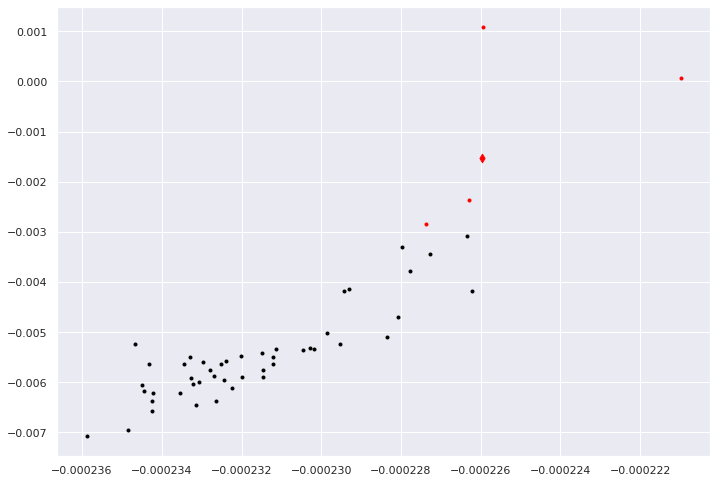

-------------------
Desulfovibrio
16 Desulfovibrio
Adjusted Rand Index: 0.25485248665258314
fowlkes_mallows_score: 0.9115695326101602
homogeneity_completeness_v_measure: 0.47017695946449123 0.1326861937192259 0.20696567967825538


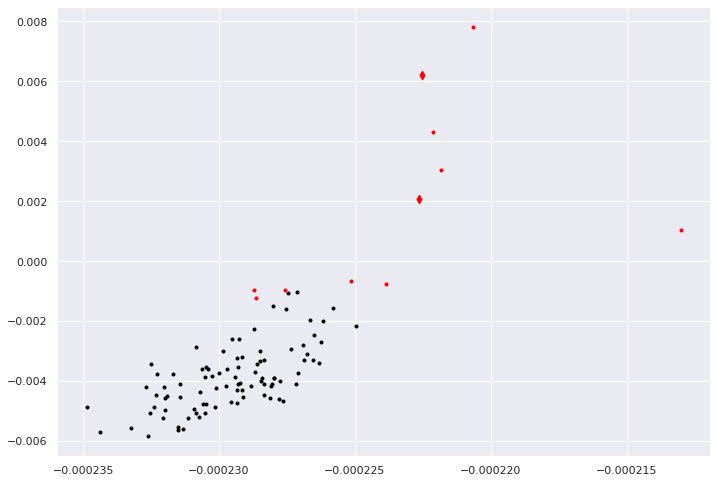

-------------------
Diplococcus
17 Diplococcus
Adjusted Rand Index: 0.2823353293413174
fowlkes_mallows_score: 0.9200777744431793
homogeneity_completeness_v_measure: 0.49166314964863234 0.1479327371530255 0.22743446912551735


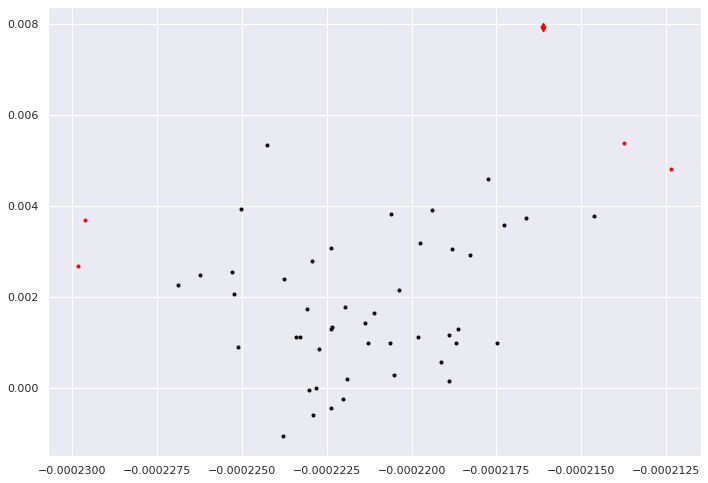

-------------------
Enterobacter
18 Enterobacter
Adjusted Rand Index: 0.6494461594334483
fowlkes_mallows_score: 0.9358505544576419
homogeneity_completeness_v_measure: 0.4807138944215439 0.42495174580067574 0.45111617266379533


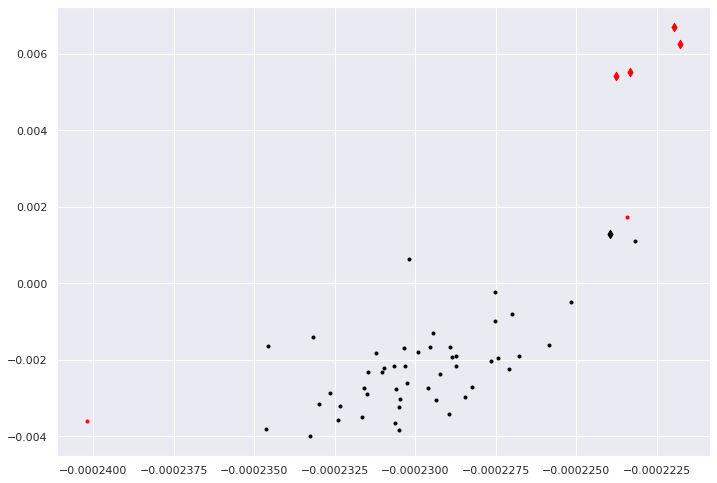

-------------------
Escherichia
19 Escherichia
Adjusted Rand Index: 0.22965519058030187
fowlkes_mallows_score: 0.8919072513434483
homogeneity_completeness_v_measure: 0.11665142926393078 0.07370717345035277 0.09033526205162619


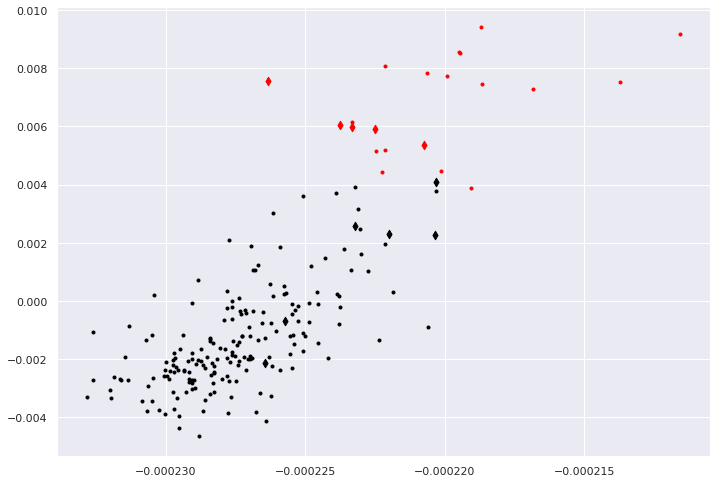

-------------------
Eubacterium
20 Eubacterium
Adjusted Rand Index: -0.030708661417322834
fowlkes_mallows_score: 0.8661085232276111
homogeneity_completeness_v_measure: 0.025698893821255796 0.006847325363367009 0.010813464167653667


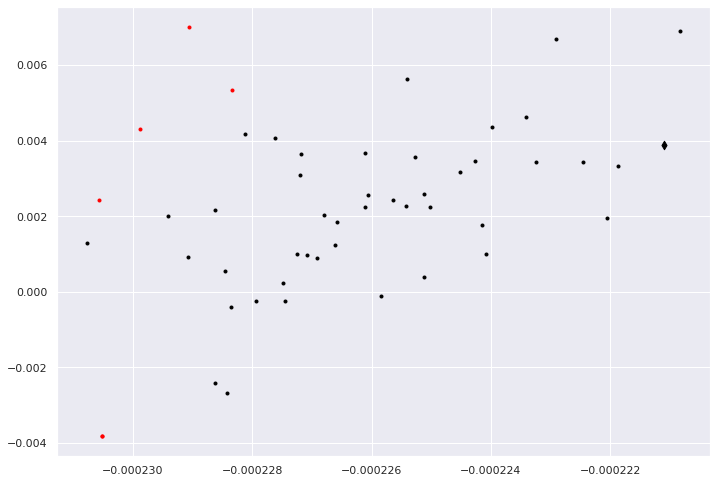

-------------------
Fischerella
21 Fischerella
Adjusted Rand Index: -0.030688622754491017
fowlkes_mallows_score: 0.8838403212710657
homogeneity_completeness_v_measure: 0.021183606185823278 0.006373772059346194 0.009799152591525005


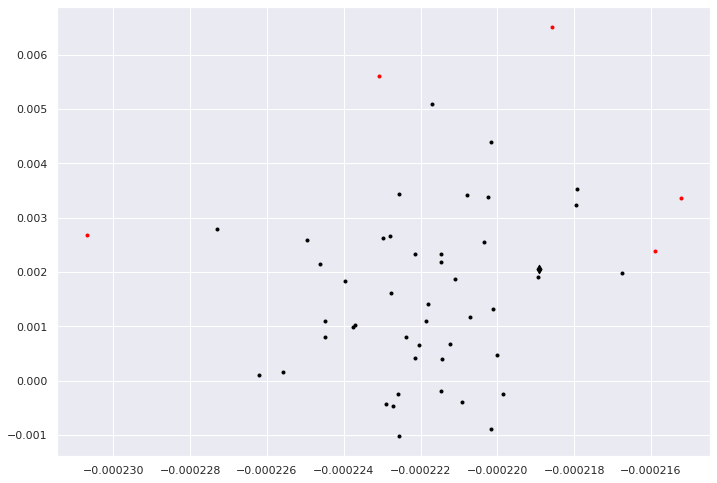

-------------------
Flavobacterium
22 Flavobacterium
Adjusted Rand Index: 0.42578759337447225
fowlkes_mallows_score: 0.9183914551600827
homogeneity_completeness_v_measure: 0.5494889745532635 0.25048345610992184 0.34410660208951227


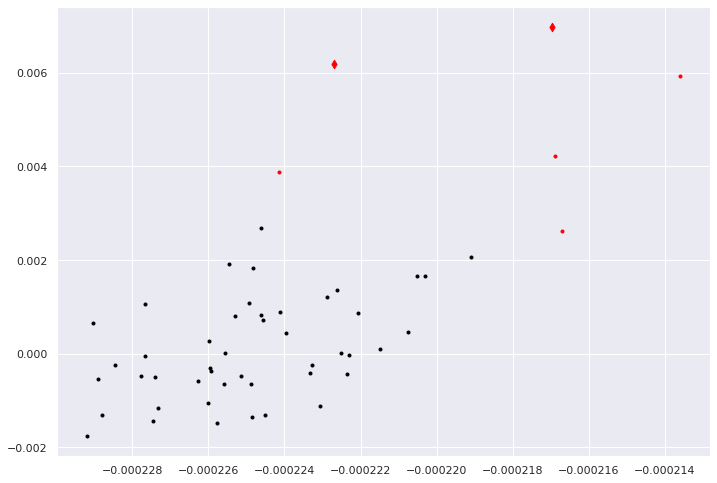

-------------------
Frankia
23 Frankia
Adjusted Rand Index: 0.2823353293413174
fowlkes_mallows_score: 0.9200777744431793
homogeneity_completeness_v_measure: 0.49166314964863234 0.1479327371530255 0.22743446912551735


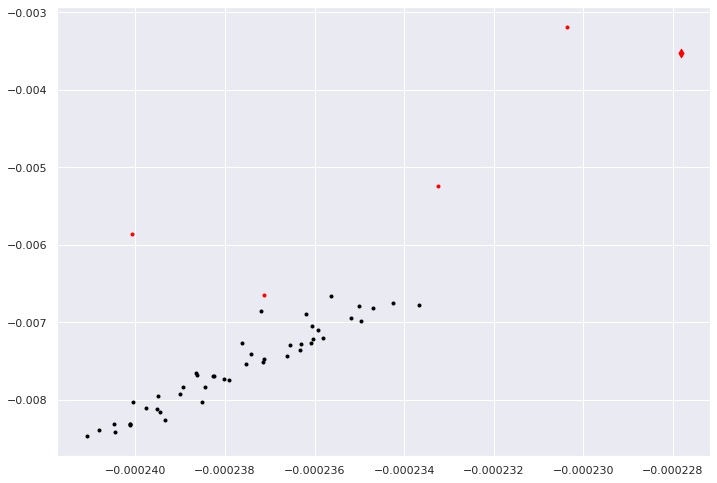

-------------------
Haemophilus
24 Haemophilus
Adjusted Rand Index: 0.3123228118679588
fowlkes_mallows_score: 0.8874270545678745
homogeneity_completeness_v_measure: 0.15791993053559578 0.12417835555215406 0.13903124017365137


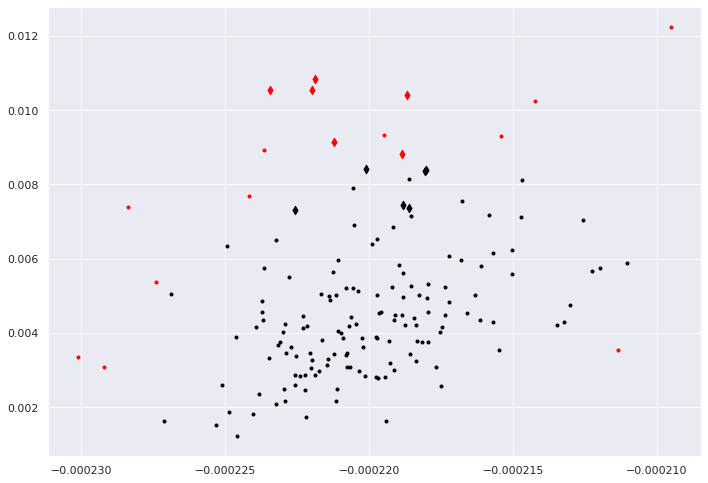

-------------------
Helicobacter
25 Helicobacter
Adjusted Rand Index: 0.06407865618109258
fowlkes_mallows_score: 0.8873591885754014
homogeneity_completeness_v_measure: 0.02581486071834593 0.00964977356077664 0.014048223843191945


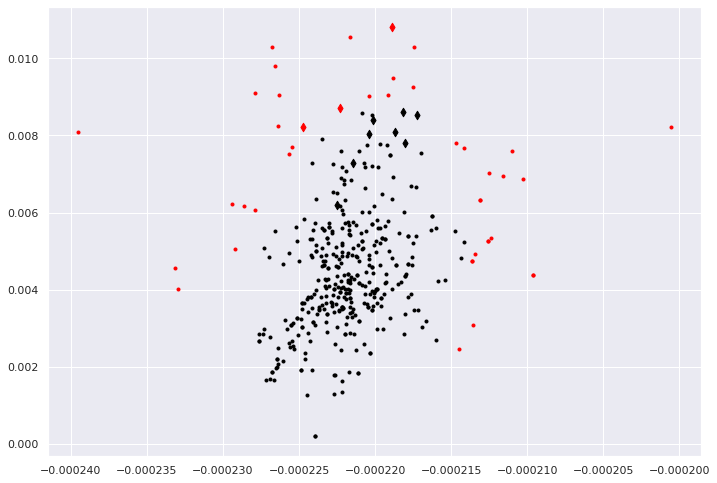

-------------------
Klebsiella
26 Klebsiella
Adjusted Rand Index: 0.2828243031075036
fowlkes_mallows_score: 0.9209363243736874
homogeneity_completeness_v_measure: 0.49166314964863217 0.14793273715302432 0.22743446912551596


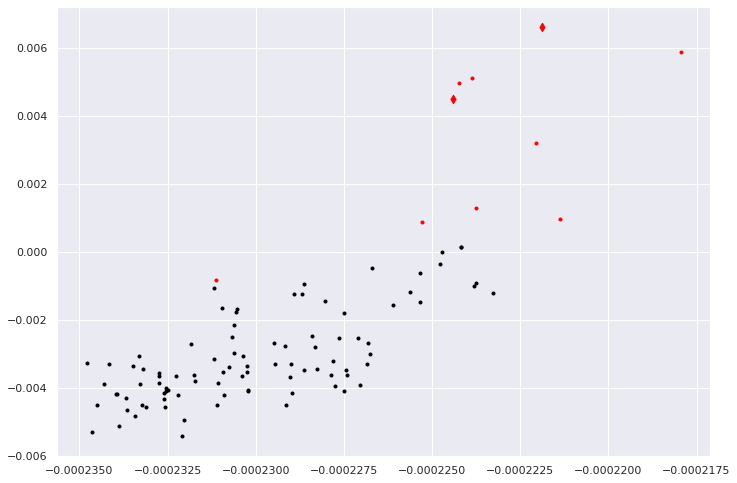

-------------------
Lactococcus
27 Lactococcus
Adjusted Rand Index: -0.08304049420258265
fowlkes_mallows_score: 0.8112639652899177
homogeneity_completeness_v_measure: 0.03305265142814905 0.03097372536331339 0.03197943719974265


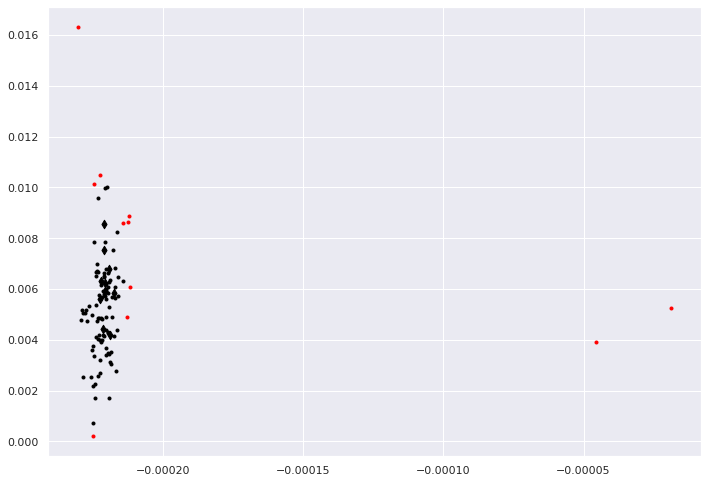

-------------------
Methanocaldococcus
28 Methanocaldococcus
Adjusted Rand Index: -0.08761576175776285
fowlkes_mallows_score: 0.8006263333730135
homogeneity_completeness_v_measure: 0.03624737285782633 0.032042727608605194 0.03401560949765492


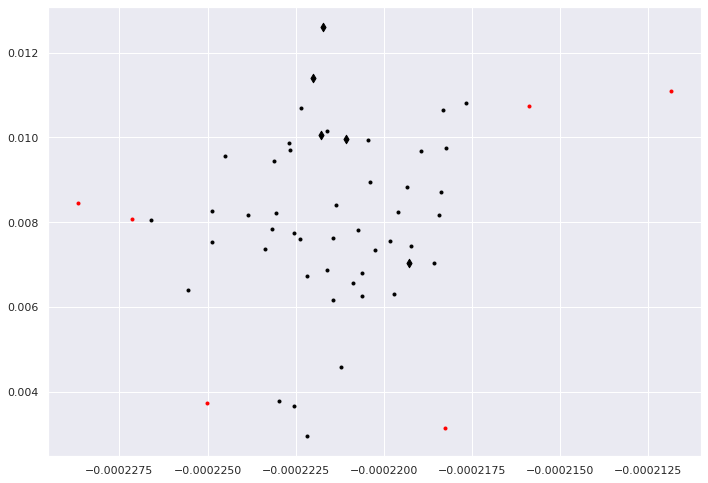

-------------------
Methylococcus
29 Methylococcus
Adjusted Rand Index: 0.23031496062992127
fowlkes_mallows_score: 0.9012575683950169
homogeneity_completeness_v_measure: 0.4507535814407424 0.12010075033949029 0.18966605081342153


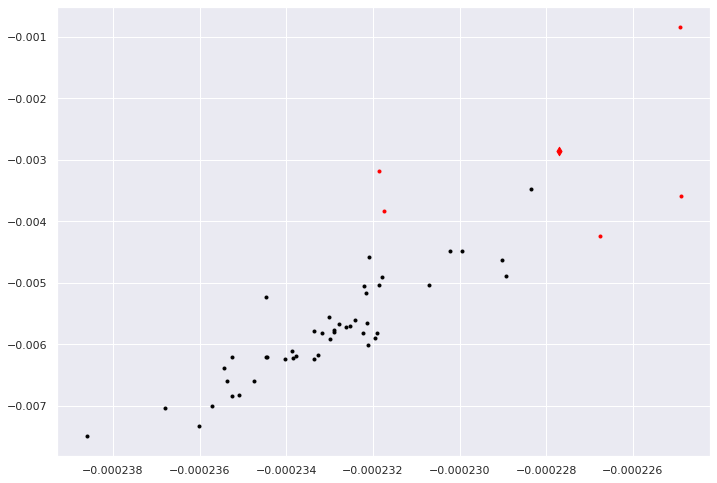

-------------------
Moraxella
30 Moraxella
Adjusted Rand Index: 0.7447833065810594
fowlkes_mallows_score: 0.9568496885950687
homogeneity_completeness_v_measure: 0.7321596405397185 0.5542157893504782 0.6308802604336415


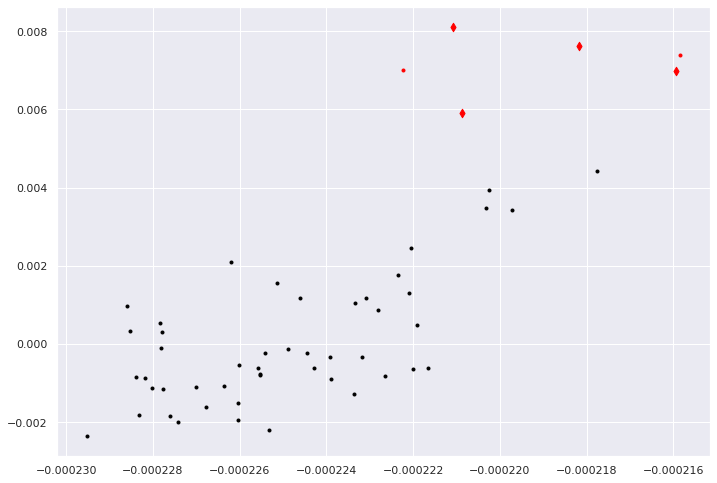

-------------------
Mycoplasma
31 Mycoplasma
Adjusted Rand Index: -0.05272274548013424
fowlkes_mallows_score: 0.8478815545719766
homogeneity_completeness_v_measure: 0.029533560624185776 0.013462814867927575 0.01849480820294072


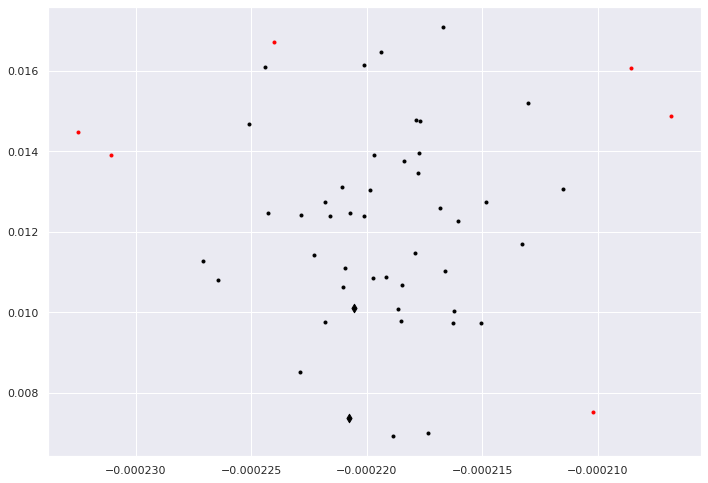

-------------------
Neisseria
32 Neisseria
Adjusted Rand Index: 0.44643398377438365
fowlkes_mallows_score: 0.9148365508269063
homogeneity_completeness_v_measure: 0.29339231671520083 0.22112299950194317 0.25218214913357173


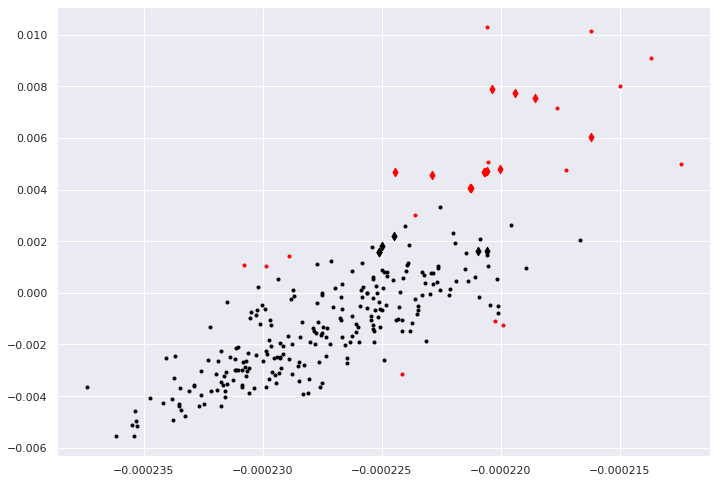

-------------------
Nocardia
33 Nocardia
Adjusted Rand Index: 0.22267379250297864
fowlkes_mallows_score: 0.9015545564162515
homogeneity_completeness_v_measure: 0.20881124961107098 0.08093465192634508 0.11665439073273529


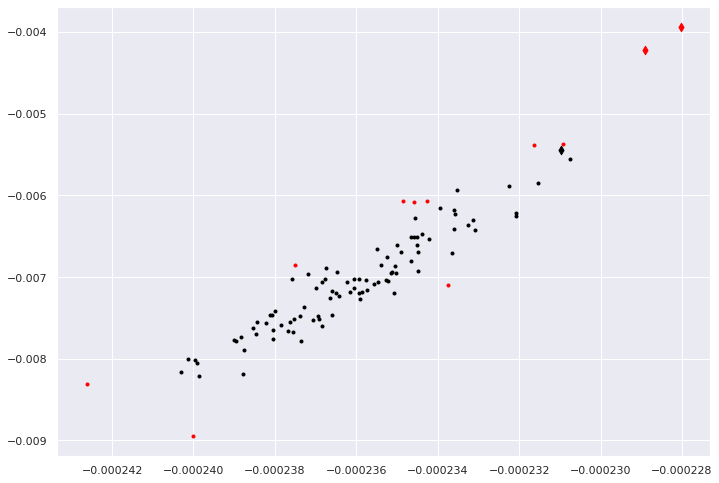

-------------------
Pseudomonas
34 Pseudomonas
Adjusted Rand Index: 0.2932460797629337
fowlkes_mallows_score: 0.8792900662596095
homogeneity_completeness_v_measure: 0.1490920873335172 0.11285679282532533 0.12846823244207764


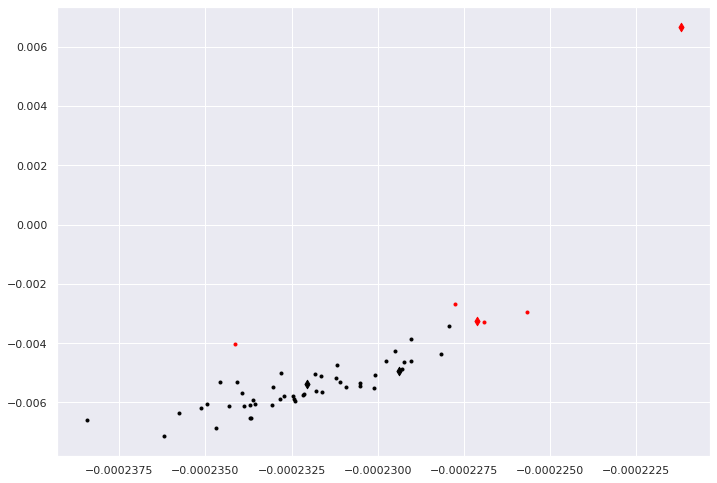

-------------------
Pyrococcus
35 Pyrococcus
Adjusted Rand Index: 0.08726858216478783
fowlkes_mallows_score: 0.8838812942987014
homogeneity_completeness_v_measure: 0.04260093205262327 0.016512001215638228 0.02379941589594289


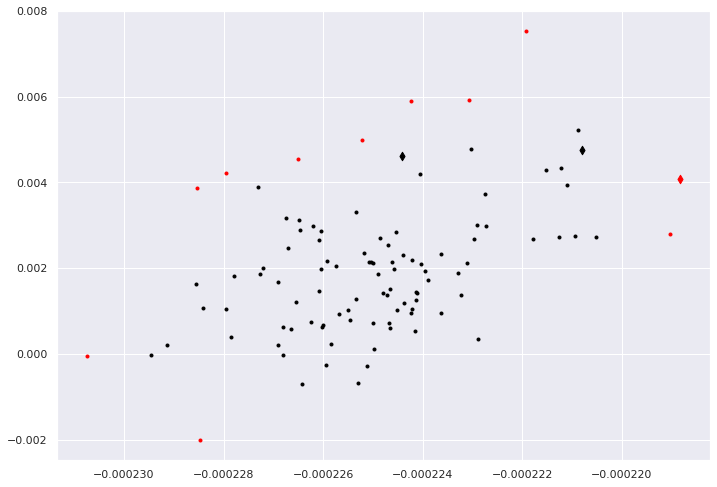

-------------------
Rhodobacter
36 Rhodobacter
Adjusted Rand Index: 0.23031496062992127
fowlkes_mallows_score: 0.9012575683950169
homogeneity_completeness_v_measure: 0.4507535814407424 0.12010075033949029 0.18966605081342153


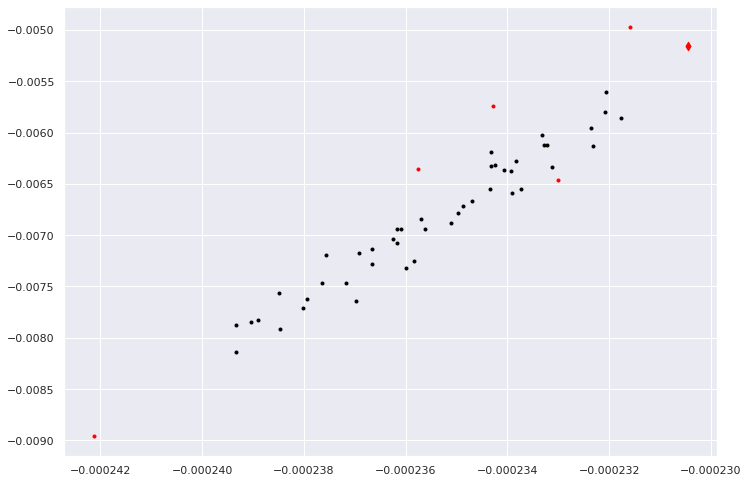

-------------------
Salmonella
37 Salmonella
Adjusted Rand Index: 0.46543826217943707
fowlkes_mallows_score: 0.9289945419419103
homogeneity_completeness_v_measure: 0.5747254356694508 0.2775476627133153 0.3743253228915326


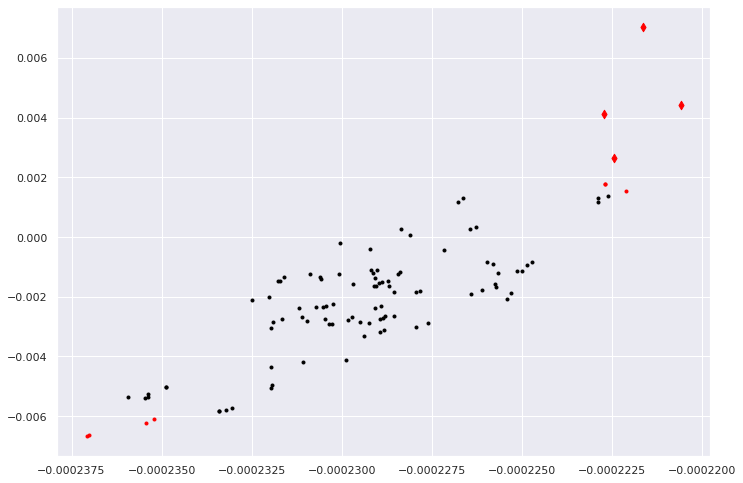

-------------------
Shewanella
38 Shewanella
Adjusted Rand Index: 0.23031496062992127
fowlkes_mallows_score: 0.9012575683950169
homogeneity_completeness_v_measure: 0.4507535814407424 0.12010075033949029 0.18966605081342153


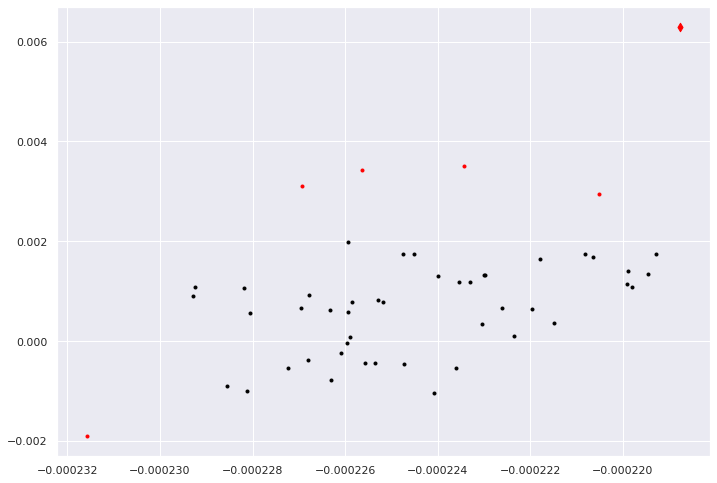

-------------------
Sphaerotilus
39 Sphaerotilus
Adjusted Rand Index: 0.5952582358193524
fowlkes_mallows_score: 0.9369687007474506
homogeneity_completeness_v_measure: 0.6392515284712909 0.3937178184645023 0.48730336091078497


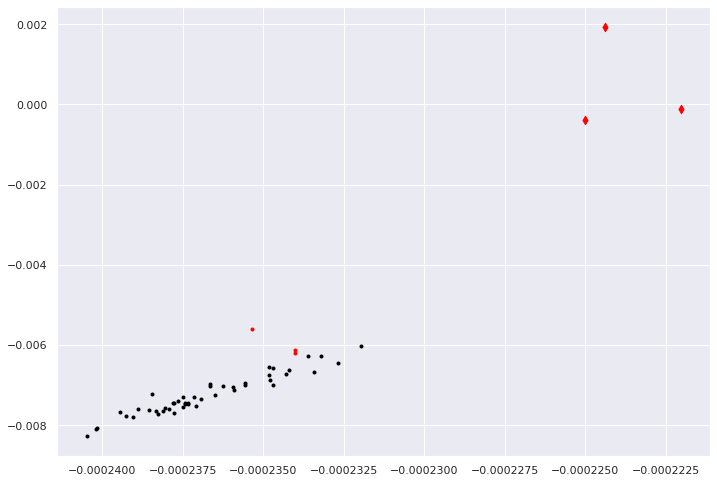

-------------------
Streptococcus
40 Streptococcus
Adjusted Rand Index: 0.03411916869419493
fowlkes_mallows_score: 0.855486135196881
homogeneity_completeness_v_measure: 0.00352085460602468 0.0025321118169286494 0.0029457284017950667


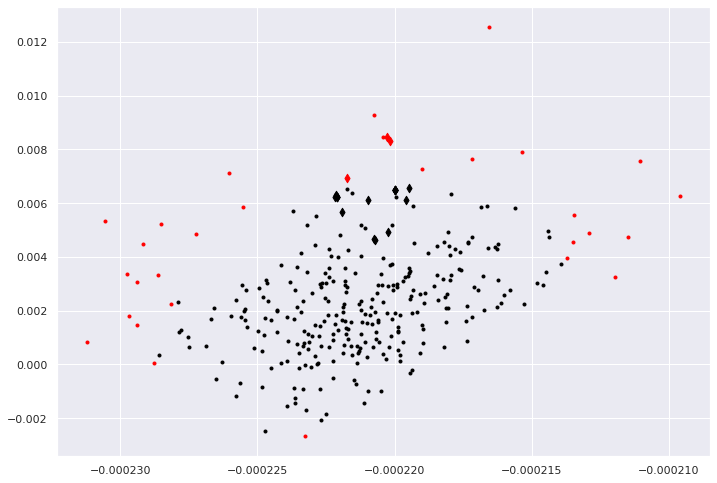

-------------------
Streptomyces
41 Streptomyces
Adjusted Rand Index: 0.5436997918410137
fowlkes_mallows_score: 0.9386503207015755
homogeneity_completeness_v_measure: 0.6167940320942551 0.3414107948907943 0.43953053637556627


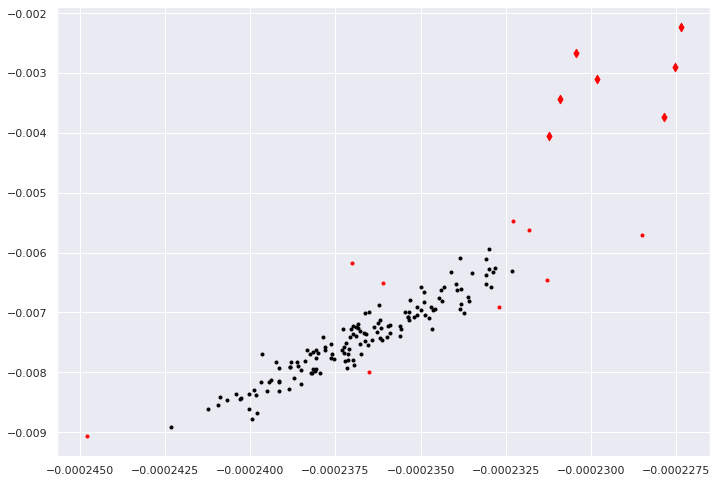

-------------------
Sulfolobus
42 Sulfolobus
Adjusted Rand Index: -0.030688622754491017
fowlkes_mallows_score: 0.8838403212710657
homogeneity_completeness_v_measure: 0.021183606185823278 0.006373772059346194 0.009799152591525005


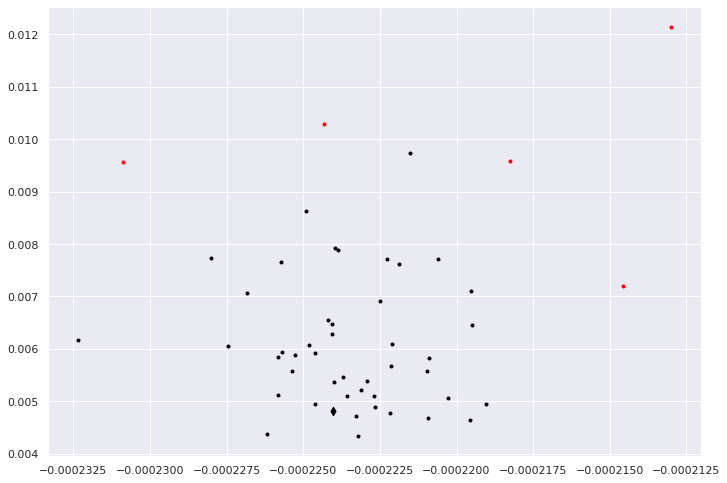

-------------------
Thermococcus
43 Thermococcus
Adjusted Rand Index: -0.030688622754491017
fowlkes_mallows_score: 0.8838403212710657
homogeneity_completeness_v_measure: 0.021183606185823278 0.006373772059346194 0.009799152591525005


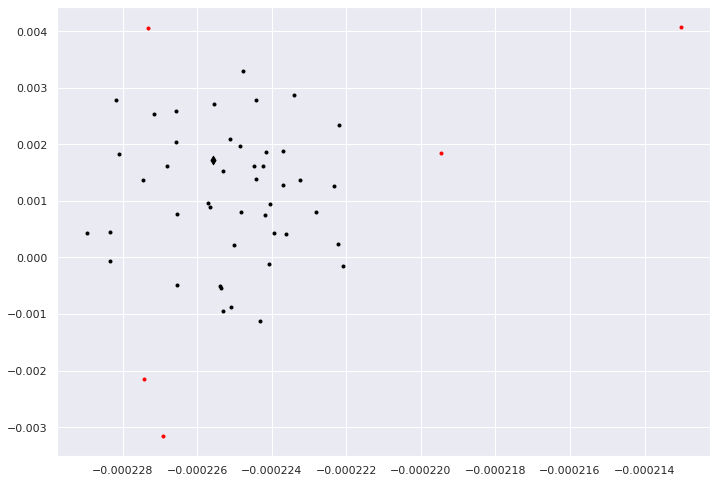

-------------------
Thermoplasma
44 Thermoplasma
Adjusted Rand Index: 0.2823353293413174
fowlkes_mallows_score: 0.9200777744431793
homogeneity_completeness_v_measure: 0.49166314964863234 0.1479327371530255 0.22743446912551735


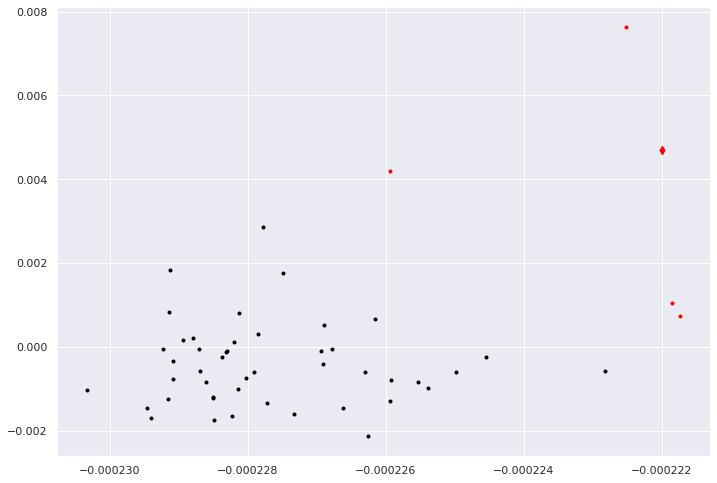

-------------------
Thermotoga
45 Thermotoga
Adjusted Rand Index: 0.25485248665258314
fowlkes_mallows_score: 0.9115695326101602
homogeneity_completeness_v_measure: 0.47017695946449123 0.1326861937192259 0.20696567967825538


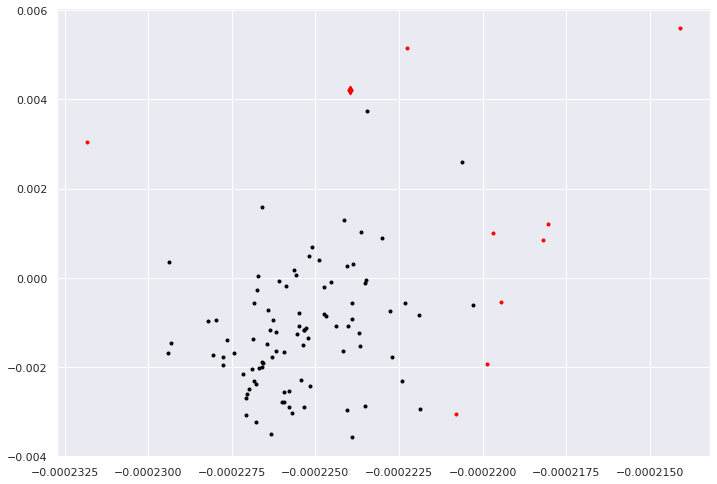

-------------------
Thermus
46 Thermus
Adjusted Rand Index: 0.43626603012634224
fowlkes_mallows_score: 0.9297267996688643
homogeneity_completeness_v_measure: 0.5630044070805916 0.2534424952159976 0.34953710118009346


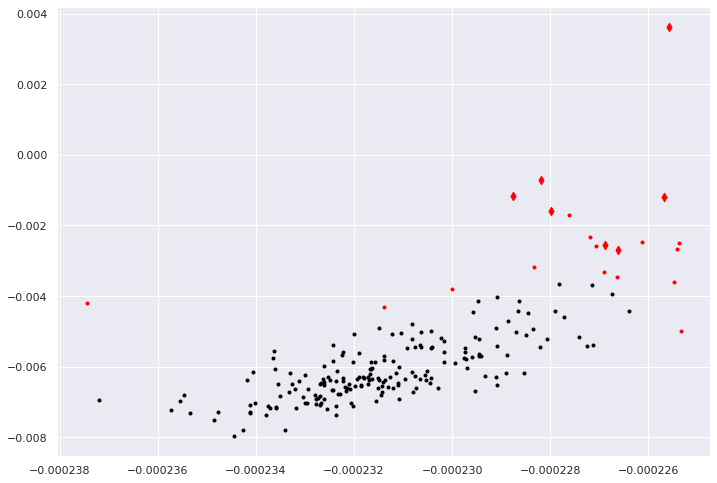

-------------------
Xanthomonas
47 Xanthomonas
Adjusted Rand Index: 0.343148210501342
fowlkes_mallows_score: 0.9152413355714001
homogeneity_completeness_v_measure: 0.3031670061722082 0.15105382184828042 0.2016399606340712


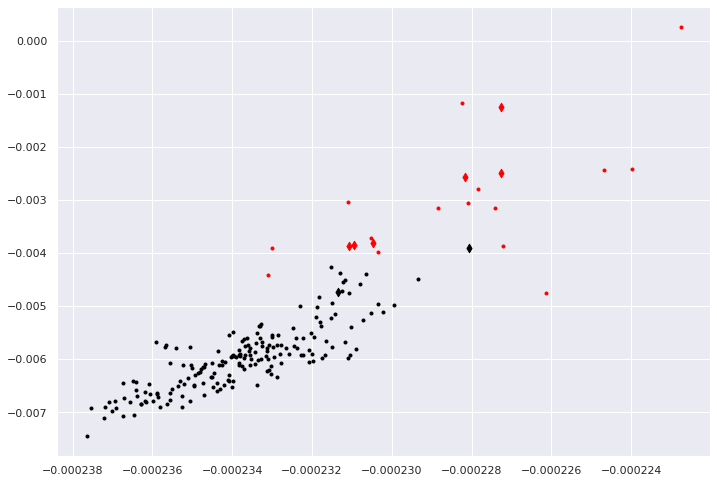

In [ ]:
from sklearn.covariance import EllipticEnvelope


# add grid search to nu


# params for dbscan
values = []
familyes = sorted(set(family_lables))
print(familyes)
for i in familyes:    
  df1= df.query('y==@i')
  df_data1 = df_data.query('family_lable==@i')
  true_labels = df_data1.is_RE.tolist()
# print(len(familyes))
  values.append({'contamination':0.02})
clustering_function(familyes,df_data, df, EllipticEnvelope, params=None)




In [ ]:
import pandas as pd

a = pd.DataFrame(all_res_table)
len(a.family_lable.unique())
a

# to csv

In [ ]:
a.sort_values(by =['fmi'] , ascending = False).to_csv('res_of_pca_tfidf.csv')

In [ ]:
a.sort_values(by =['tp'], ascending = False)

In [ ]:
import pandas as pd
from scipy.stats import pearsonr
import statsmodels.formula.api as smf

# Create a sample dataset

# Calculate the correlation coefficient
corr, _ = pearsonr(a['fmi'], a['family_size'])
print('Correlation coefficient:', corr)

# Fit a linear regression model
model = smf.ols('fmi ~ family_size', data=a).fit()
print(model.summary())

In [ ]:
import pandas as pd
from scipy.stats import pearsonr
import statsmodels.formula.api as smf

# Create a sample dataset

# Calculate the correlation coefficient
corr, _ = pearsonr(a['fmi'], a['re_size'])
print('Correlation coefficient:', corr)

# Fit a linear regression model
model = smf.ols('fmi ~ re_size', data=a).fit()
print(model.summary())